In [1]:
import gpxpy
import gpxpy.gpx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from folium.vector_layers import Rectangle
from shapely.geometry import LineString
from shapely.ops import unary_union
from shapely.geometry import Point
import pandas as pd
from math import exp, sqrt, pi
import networkx as nx
from shapely.geometry import LineString, Point
from geopy.distance import geodesic, great_circle

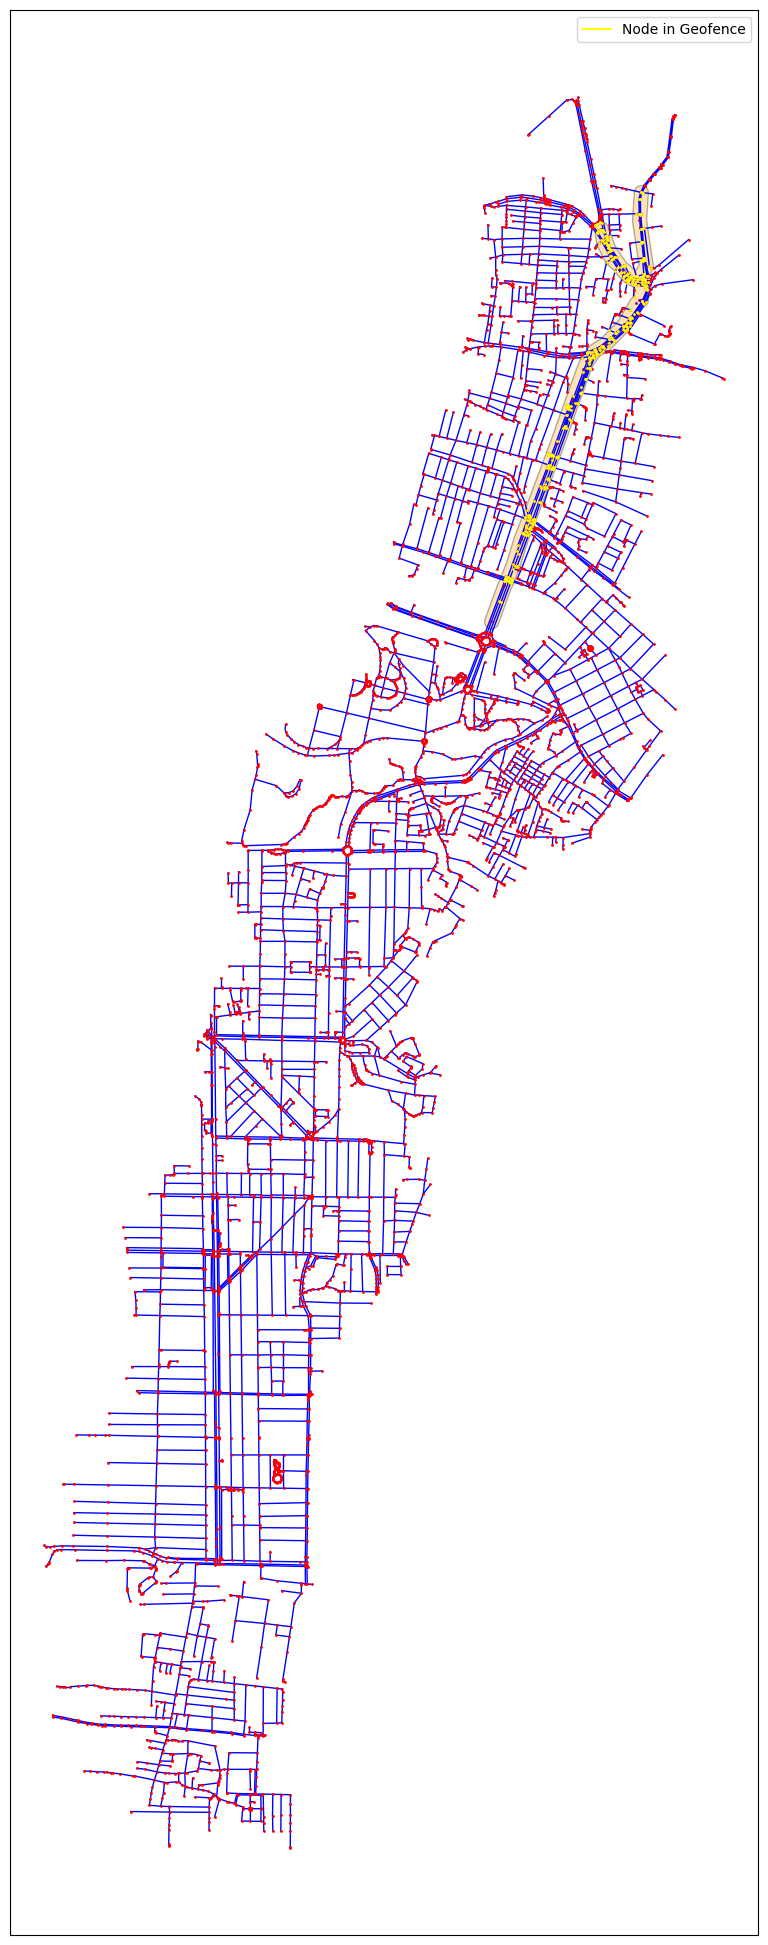

407
[(77.5910327, 12.9530502), (77.5950172, 12.9623725), (77.5923176, 12.9561077), (77.5923908, 12.9560373), (77.5920133, 12.9561224), (77.592026, 12.9561944), (77.595081, 12.9666796), (77.5951123, 12.9665662), (77.5951391, 12.9664694), (77.5951691, 12.9663867), (77.5951853, 12.9663361), (77.5952036, 12.9662907), (77.5952255, 12.9662362), (77.5952658, 12.9661547), (77.5952791, 12.966131), (77.5954261, 12.9659076), (77.5956891, 12.9655239), (77.5958136, 12.9653487), (77.5959105, 12.9652286), (77.5959968, 12.9651535), (77.5960612, 12.9651162), (77.5961828, 12.9650479), (77.5963127, 12.964999), (77.5965689, 12.9641342), (77.5963566, 12.96381), (77.5960744, 12.9634343), (77.5931953, 12.9584317), (77.5930476, 12.9580395), (77.5930224, 12.9579705), (77.5928942, 12.9576497), (77.5928774, 12.9576027), (77.592807, 12.9574198), (77.5927679, 12.9573095), (77.5927415, 12.9572348), (77.5925577, 12.9567465), (77.5923056, 12.9560758), (77.5936423, 12.9599902), (77.593721, 12.9601965), (77.5937694, 12

In [2]:
fp = "/Users/ashwin/Desktop/IIIT/Re_ OSM version - within 500m of the path/For_Route_g1_i150_500m.shp"
data = gpd.read_file(fp)

G = nx.Graph()

for i, node in enumerate(G.nodes()):
    G.nodes[node]['shapefile_index'] = i

for line in data.geometry:
    if line.geom_type == 'LineString':
        start, end = Point(line.coords[0]), Point(line.coords[-1])
        length = line.length
        G.add_node(tuple(start.coords[0]), pos=tuple(start.coords[0]))
        G.add_node(tuple(end.coords[0]), pos=tuple(end.coords[0]))
        G.add_edge(tuple(start.coords[0]), tuple(end.coords[0]), geometry=line)

gpx_file_path = '/Users/ashwin/Desktop/IIIT/Re_ OSM version - within 500m of the path/ff3e72e1-90d5-4208-af3d-cf19a6c38fac_493.gpx'
with open(gpx_file_path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

start_index_2 = 80
end_index_2 = 120
observations_2 = []

for track in gpx.tracks:
    for segment in track.segments:
        for i, point in enumerate(segment.points):
            if start_index_2 <= i < end_index_2:
                observations_2.append((point.longitude, point.latitude))

observations_2_no_duplicates = []
for i, point in enumerate(observations_2):
    if i == 0 or point != observations_2[i - 1]:
        observations_2_no_duplicates.append(point)

gpx_path = LineString(observations_2_no_duplicates)
gpx_gdf = gpd.GeoDataFrame(geometry=[gpx_path], crs="EPSG:4326")
gpx_gdf = gpx_gdf.to_crs(epsg=3857)

geofence = gpx_gdf.buffer(30)
geofence = geofence.to_crs(epsg=4326)

connected_components = sorted(nx.connected_components(G), key=len, reverse=True)

if len(connected_components) > 0:
    subgraph_2 = G.subgraph(connected_components[0]).copy()
    pos_2 = nx.get_node_attributes(subgraph_2, 'pos')

    states_in_geofence_2 = []
    for node, position in pos_2.items():
        point = Point(position)
        if geofence.geometry[0].contains(point):
            states_in_geofence_2.append(position)

    fig, ax = plt.subplots(figsize=(30, 25))

    for edge in subgraph_2.edges(data=True):
        line = edge[2]['geometry']
        x, y = line.xy
        ax.plot(x, y, color='blue', linewidth=1)

    nx.draw_networkx_nodes(subgraph_2, pos_2, ax=ax, node_size=1, node_color='red')

    for point in observations_2_no_duplicates:
        ax.plot(point[0], point[1], marker='o', color='purple', markersize=1)

    geofence.plot(ax=ax, color='orange', alpha=0.3, edgecolor='black')

    for node in states_in_geofence_2:
        ax.plot(node[0], node[1], marker='o', color='yellow', markersize=1, label="Node in Geofence")

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:1], labels[:1])

    plt.show()
    print(len(states_in_geofence_2))
    print(states_in_geofence_2)

def calculate_geodesic_distance(points):
    total_distance = 0.0
    for i in range(1, len(points)):
        total_distance += geodesic(points[i-1], points[i]).kilometers
    return total_distance

total_geodesic_distance_km_2 = calculate_geodesic_distance(observations_2_no_duplicates)
print(f"Total geodesic distance of observation path: {total_geodesic_distance_km_2:.2f} km")

print(len(observations_2_no_duplicates))
print(observations_2_no_duplicates)

In [3]:
observations_2_no_duplicates = []
for i, point in enumerate(observations_2):
    if i == 0 or point != observations_2[i - 1]:
        observations_2_no_duplicates.append(point)

def find_closest_nodes_with_distances(graph, observations):
    node_positions = nx.get_node_attributes(graph, 'pos')
    closest_nodes = []
    distances = []
    for obs in observations:
        closest_node = min(
            node_positions.keys(),
            key=lambda node: geodesic(obs, node_positions[node]).meters,
        )
        closest_distance = geodesic(obs, node_positions[closest_node]).meters
        closest_nodes.append(closest_node)
        distances.append(closest_distance)
    return closest_nodes, distances
closest_nodes_to_observations, distances_to_closest_nodes = find_closest_nodes_with_distances(G, observations_2_no_duplicates)
print("Closest nodes to observations:", closest_nodes_to_observations)
print("Distances to closest nodes (meters):", distances_to_closest_nodes)

Closest nodes to observations: [(77.5907372, 12.9517964), (77.591235, 12.9538022), (77.591235, 12.9538022), (77.591235, 12.9538022), (77.5913069, 12.953776), (77.591551, 12.9544331), (77.5919271, 12.9555743), (77.5920448, 12.9558165), (77.5921615, 12.9560201), (77.5927679, 12.9573095), (77.5932349, 12.9590165), (77.5938603, 12.9606895), (77.5942564, 12.9615997), (77.5943883, 12.961759), (77.5946817, 12.9624034), (77.5950607, 12.9625024), (77.5958092, 12.9633107), (77.5963218, 12.9638482), (77.5963566, 12.96381), (77.5965177, 12.9642362), (77.5965177, 12.9642362), (77.5965005, 12.9648704), (77.5953202, 12.9657817), (77.5949963, 12.9665283), (77.5949328, 12.9669131), (77.5952255, 12.9662362), (77.5958136, 12.9653487), (77.5959968, 12.9651535), (77.5961425, 12.965111), (77.5963127, 12.964999), (77.5963127, 12.964999), (77.5966312, 12.9657761), (77.5964542, 12.9669352), (77.5964033, 12.9675131), (77.5964609, 12.9683084)]
Distances to closest nodes (meters): [11.699304552127918, 7.234564829

In [4]:
score = None
pred = None
shapefile_indices = None
IT = None

def create_graph_from_shapefile(filepath):
    data = gpd.read_file(filepath)
    G = nx.Graph()
    for idx, line in enumerate(data.geometry):
        if line.geom_type == 'LineString':
            start, end = Point(line.coords[0]), Point(line.coords[-1])
            geodesic_distance = geodesic(start.coords[0], end.coords[0]).meters
            G.add_node(tuple(start.coords[0]), pos=tuple(start.coords[0]), shapefile_index=idx)
            G.add_node(tuple(end.coords[0]), pos=tuple(end.coords[0]), shapefile_index=idx)
            G.add_edge(
                tuple(start.coords[0]),
                tuple(end.coords[0]),
                geometry=line,
                weight=geodesic_distance,
            )
    return G

def calculate_graph_distances(graph, states):
    n_states = len(states)
    distances = np.zeros((n_states, n_states))
    for i in range(n_states):
        for j in range(n_states):
            if i != j:
                try:
                    path_length = nx.shortest_path_length(
                        graph,
                        source=tuple(states[i]),
                        target=tuple(states[j]),
                        weight="weight",
                    )
                    distances[i, j] = path_length
                except nx.NetworkXNoPath:
                    distances[i, j] = np.inf
    return distances

def calculate_beta_values(observations, closest_nodes_to_observations, state_distances_2):
    n_obs = len(observations)
    beta_values = []
    node_to_index = {node: idx for idx, node in enumerate(closest_nodes_to_observations)}
    for k in range(n_obs - 1): 
        node_1 = closest_nodes_to_observations[k]
        node_2 = closest_nodes_to_observations[k + 1]
        idx_1 = node_to_index[node_1]
        idx_2 = node_to_index[node_2]
        great_circle_distance = geodesic(observations[k], observations[k + 1]).meters
        route_distance = state_distances_2[idx_1, idx_2]
        diff_distance = abs(great_circle_distance - route_distance)
        beta_values.append(diff_distance)
    mediant_value = np.median(beta_values)
    beta = mediant_value / np.log(2)
    print(f"Beta value: {beta}")
    return beta

def calculate_transition_matrix(states, zVec, observations, state_distances):
    n_states = len(states)
    n_obs = len(zVec)
    TRANS = np.zeros((n_states, n_states, n_obs))
    beta = calculate_beta_values(observations, closest_nodes_to_observations, state_distances)
    for k in range(n_obs):
        for i in range(n_states):
            for j in range(n_states):
                dij = abs(state_distances[i, j] - zVec[k])
                TRANS[i, j, k] = (1 / beta) * np.exp(-dij / beta)
        
        row_sums = np.sum(TRANS[:, :, k], axis=1)
        TRANS[:, :, k] = np.divide(TRANS[:, :, k], row_sums[:, None], where=row_sums[:, None] != 0)
    return TRANS

def calculate_emission_matrix(states, observations):
    n_states = len(states)
    n_obs = len(observations)
    distances = np.zeros((n_states, n_obs))
    for i in range(n_states):
        for j in range(n_obs):
            distances[i, j] = great_circle(states[i], observations[j]).m
    sigz = 1.4826 * np.median(distances_to_closest_nodes)
    print(sigz)
    EMIS = (1 / (np.sqrt(2 * np.pi) * sigz)) * np.exp(-0.5 * (distances / sigz) ** 2)
    return EMIS

def viterbi_algorithm(states, observations, zVec, PRIOR, state_distances):
    global score, pred, IT
    n_states = len(states)
    T = len(observations)
    TRANS = calculate_transition_matrix(states, zVec, observations, state_distances)
    EMIS = calculate_emission_matrix(states, observations)
    score = np.zeros((n_states, T))
    pred = np.zeros((n_states, T), dtype=int)
    score[:, 0] = PRIOR * EMIS[:, 0]
    for t in range(1, T):
        temp_score = score[:, t - 1][:, None] * TRANS[:, :, t - 1]
        pred[:, t] = np.argmax(temp_score, axis=0)
        score[:, t] = np.max(temp_score, axis=0) * EMIS[:, t]
    IT = np.zeros(T, dtype=int)
    IT[-1] = np.argmax(score[:, -1])
    for t in range(T - 1, 0, -1):
        IT[t - 1] = pred[IT[t], t]
    return IT

def calculate_geodesic_distance(points):
    total_distance = 0.0
    for i in range(1, len(points)):
        total_distance += geodesic(points[i-1], points[i]).meters
    return total_distance

fp = "/Users/ashwin/Desktop/IIIT/Re_ OSM version - within 500m of the path/For_Route_g1_i150_500m.shp"
data = gpd.read_file(fp)
G = create_graph_from_shapefile(fp)
gpx_file_path = '/Users/ashwin/Desktop/IIIT/Re_ OSM version - within 500m of the path/ff3e72e1-90d5-4208-af3d-cf19a6c38fac_493.gpx'
with open(gpx_file_path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)
obs_2 = np.array(observations_2_no_duplicates)
s = np.array(states_in_geofence_2)
s_2 = np.array(closest_nodes_to_observations)
zVec_2 = [geodesic(obs_2[i], obs_2[i + 1]).meters for i in range(len(obs_2) - 1)]
state_distances = calculate_graph_distances(G, s)
state_distances_2 = calculate_graph_distances(G, s_2)
PRIOR_2 = np.ones(len(states_in_geofence_2)) / len(states_in_geofence_2)
matched_states_2 = viterbi_algorithm(states_in_geofence_2, obs_2, zVec_2, PRIOR_2, state_distances)
total_geodesic_distance_km_2 = calculate_geodesic_distance(observations_2_no_duplicates)
print(matched_states_2)
matched_coords = [states_in_geofence_2[i] for i in matched_states_2]
matched_shapefile_indices = [G.nodes[tuple(coord)]['shapefile_index'] for coord in matched_coords]
print("Matched shapefile indices:", matched_shapefile_indices)

Beta value: 33.0090262271738
5.147669614392617
[  0 324 324 324 305 145 362 359 143  32 368 371  39 272 164   1  48  51
  52  52  52 122  99 132  89  12  17  19 339 341 341  69 383 289 373]
Matched shapefile indices: [4890, 5100, 5100, 5100, 5095, 4886, 5864, 5858, 4875, 4144, 5875, 5878, 889, 4899, 3583, 3581, 4295, 900, 901, 901, 901, 2927, 2936, 5012, 1721, 6119, 858, 860, 5595, 5597, 5597, 4244, 5949, 4814, 5946]


In [5]:
matched_coordinates_2 = [states_in_geofence_2[state_idx] for state_idx in matched_states_2]

unique_matched_coordinates_2 = [
    coord for i, coord in enumerate(matched_coordinates_2)
    if i == 0 or coord != matched_coordinates_2[i - 1]
]

print(f"Number of unique matched coordinates: {len(unique_matched_coordinates_2)}")
for coord in unique_matched_coordinates_2:
    lon, lat = coord
    print(f"Latitude: {lat}, Longitude: {lon}")

print("\nAll matched coordinates:")
for coord in matched_coordinates_2:
    lon, lat = coord
    print(f"Latitude: {lat}, Longitude: {lon}")


Number of unique matched coordinates: 30
Latitude: 12.9530502, Longitude: 77.5910327
Latitude: 12.9538022, Longitude: 77.591235
Latitude: 12.953776, Longitude: 77.5913069
Latitude: 12.9544331, Longitude: 77.591551
Latitude: 12.9555743, Longitude: 77.5919271
Latitude: 12.9558165, Longitude: 77.5920448
Latitude: 12.9560201, Longitude: 77.5921615
Latitude: 12.9573095, Longitude: 77.5927679
Latitude: 12.9590165, Longitude: 77.5932349
Latitude: 12.9606895, Longitude: 77.5938603
Latitude: 12.9615997, Longitude: 77.5942564
Latitude: 12.9623193, Longitude: 77.5944061
Latitude: 12.9624034, Longitude: 77.5946817
Latitude: 12.9623725, Longitude: 77.5950172
Latitude: 12.9633107, Longitude: 77.5958092
Latitude: 12.9637594, Longitude: 77.5962009
Latitude: 12.9642281, Longitude: 77.5965222
Latitude: 12.9648704, Longitude: 77.5965005
Latitude: 12.9659381, Longitude: 77.5953318
Latitude: 12.9665283, Longitude: 77.5949963
Latitude: 12.9669131, Longitude: 77.5949328
Latitude: 12.9662362, Longitude: 77.59


--- Path Segment Distances (Shortest Path Between Consecutive Matched States) ---
Segment from state 4890 to 5100: 43.27 meters
Segment from state 5100 to 5100: 0.00 meters
Segment from state 5100 to 5100: 0.00 meters
Segment from state 5100 to 5095: 8.05 meters
Segment from state 5095 to 4886: 31.49 meters
Segment from state 4886 to 5864: 63.14 meters
Segment from state 5864 to 5858: 22.50 meters
Segment from state 5858 to 4875: 14.37 meters
Segment from state 4875 to 4144: 97.23 meters
Segment from state 4144 to 5875: 114.74 meters
Segment from state 5875 to 5878: 80.54 meters
Segment from state 5878 to 889: 84.35 meters
Segment from state 889 to 4899: 44.91 meters
Segment from state 4899 to 3583: 30.84 meters
Segment from state 3583 to 3581: 37.78 meters
Segment from state 3581 to 4295: 125.77 meters
Segment from state 4295 to 900: 45.05 meters
Segment from state 900 to 901: 37.59 meters
Segment from state 901 to 901: 0.00 meters
Segment from state 901 to 901: 0.00 meters
Segment f

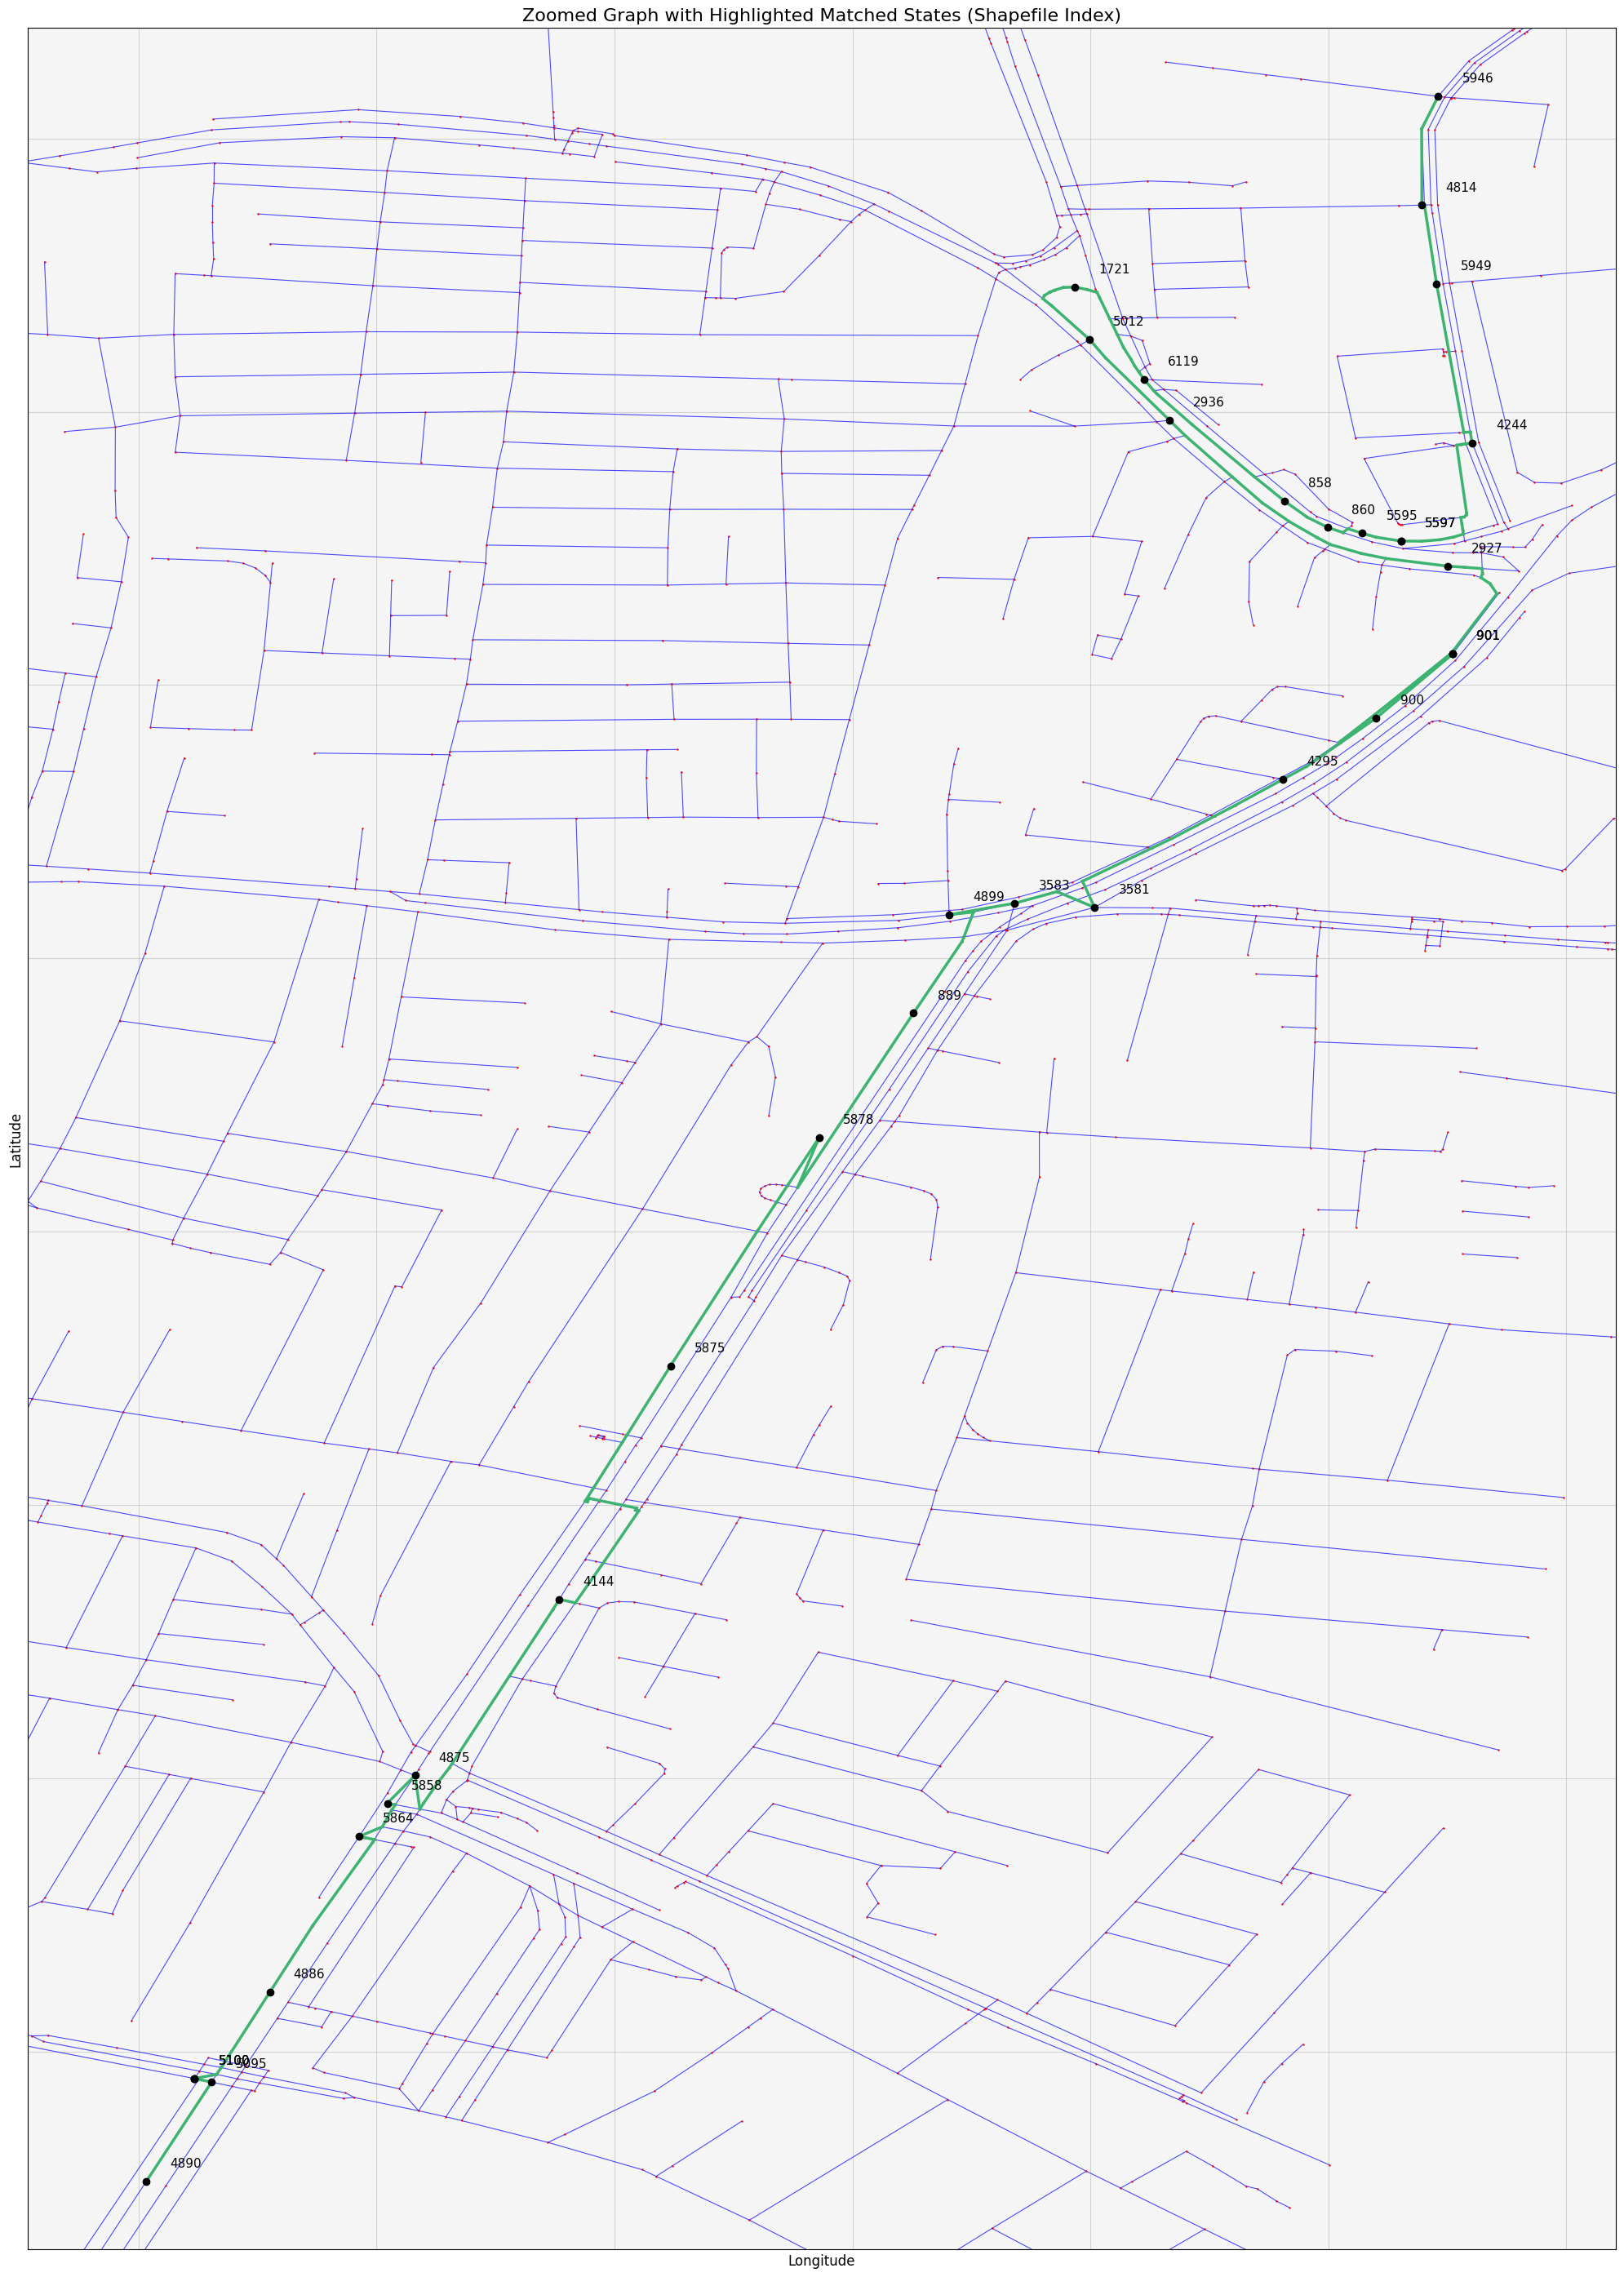

In [6]:
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from geopy.distance import geodesic

fp = "/Users/ashwin/Desktop/IIIT/Re_ OSM version - within 500m of the path/For_Route_g1_i150_500m.shp"
data = gpd.read_file(fp)

G = nx.Graph()
coord_to_index = {}

for idx, line in enumerate(data.geometry):
    if line.geom_type == 'LineString':
        start, end = Point(line.coords[0]), Point(line.coords[-1])
        start_coord = tuple(start.coords[0])
        end_coord = tuple(end.coords[-1])
        G.add_node(start_coord, pos=start_coord)
        G.add_node(end_coord, pos=end_coord)
        G.add_edge(start_coord, end_coord, geometry=line)
        coord_to_index[start_coord] = idx
        coord_to_index[end_coord] = idx

pos = nx.get_node_attributes(G, 'pos')

valid_highlighted_nodes_2 = [tuple(coord) for coord in matched_coordinates_2 if tuple(coord) in pos]
valid_highlighted_nodes_2 = [node for node in valid_highlighted_nodes_2 if node in pos]

def geodesic_distance(a, b):
    return geodesic(a, b).meters

def find_shortest_path_between_nodes(G, start_node, end_node):
    return nx.shortest_path(G, source=start_node, target=end_node, weight=lambda u, v, d: geodesic_distance(pos[u], pos[v]))

def create_path_from_highlighted_nodes(G, nodes):
    path = [nodes[0]]
    visited = set(path)
    for i in range(len(nodes) - 1):
        segment = find_shortest_path_between_nodes(G, nodes[i], nodes[i + 1])
        for node in segment[1:]:
            if node not in visited:
                path.append(node)
                visited.add(node)
    return path

def calculate_path_segment_distances(G, nodes):
    segment_distances = []
    total_path_length = 0
    print("\n--- Path Segment Distances (Shortest Path Between Consecutive Matched States) ---")
    for i in range(len(nodes) - 1):
        segment = find_shortest_path_between_nodes(G, nodes[i], nodes[i + 1])
        distance = 0
        for j in range(len(segment) - 1):
            pt1 = segment[j]
            pt2 = segment[j + 1]
            distance += geodesic(pos[pt1], pos[pt2]).meters
        segment_distances.append(distance)
        total_path_length += distance
        print(f"Segment from state {coord_to_index[nodes[i]]} to {coord_to_index[nodes[i+1]]}: {distance:.2f} meters")
    print(f"\nTotal path length over shortest paths: {total_path_length:.2f} meters")
    return segment_distances, total_path_length

if len(valid_highlighted_nodes_2) > 2:
    path_nodes_2 = create_path_from_highlighted_nodes(G, valid_highlighted_nodes_2)
else:
    path_nodes_2 = valid_highlighted_nodes_2

segment_distances, total_path_length = calculate_path_segment_distances(G, valid_highlighted_nodes_2)

fig, ax = plt.subplots(figsize=(20, 28))

for edge in G.edges(data=True):
    line = edge[2]['geometry']
    x, y = line.xy
    ax.plot(x, y, color='blue', linewidth=0.8, alpha=0.7)

nx.draw_networkx_nodes(G, pos, ax=ax, node_size=0.5, node_color='red')

for node in valid_highlighted_nodes_2:
    x, y = node
    ax.plot(x, y, marker='o', color='black', markersize=6, zorder=3)
    idx_label = coord_to_index.get(node, 'N/A')
    ax.text(x + 0.0001, y + 0.0001, str(idx_label), fontsize=11, color='black', zorder=4)

for i in range(len(path_nodes_2) - 1):
    start = path_nodes_2[i]
    end = path_nodes_2[i + 1]
    line = LineString([Point(start), Point(end)])
    x, y = line.xy
    ax.plot(x, y, color='mediumseagreen', linewidth=2.5, linestyle='-', zorder=2)
x_coords = [coord[0] for coord in path_nodes_2]
y_coords = [coord[1] for coord in path_nodes_2]
margin = 0.0005
ax.set_xlim(min(x_coords) - margin, max(x_coords) + margin)
ax.set_ylim(min(y_coords) - margin, max(y_coords) + margin)
ax.set_facecolor('whitesmoke')
ax.tick_params(axis='both', which='major', labelsize=10)
plt.title("Zoomed Graph with Highlighted Matched States (Shapefile Index)", fontsize=16)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.grid(True, linestyle='-', alpha=0.5)
plt.tight_layout()
plt.show()


+---------------+------------+-----------------+
|   Path Length |   Geodesic |   distance_diff |
+===============+============+=================+
|       43.2721 | 149.185    |      105.912    |
+---------------+------------+-----------------+
|        0      |   8.33779  |        8.33779  |
+---------------+------------+-----------------+
|        0      |   0.751645 |        0.751645 |
+---------------+------------+-----------------+
|        0      |  20.9349   |       20.9349   |
+---------------+------------+-----------------+
|       47.2233 |  77.642    |       30.4187   |
+---------------+------------+-----------------+
|       63.1425 | 105.949    |       42.8063   |
+---------------+------------+-----------------+
|       21.9787 |  51.5959   |       29.6172   |
+---------------+------------+-----------------+
|       13.9145 |  34.1086   |       20.1941   |
+---------------+------------+-----------------+
|       81.4448 | 176.944    |       95.4991   |
+---------------+---

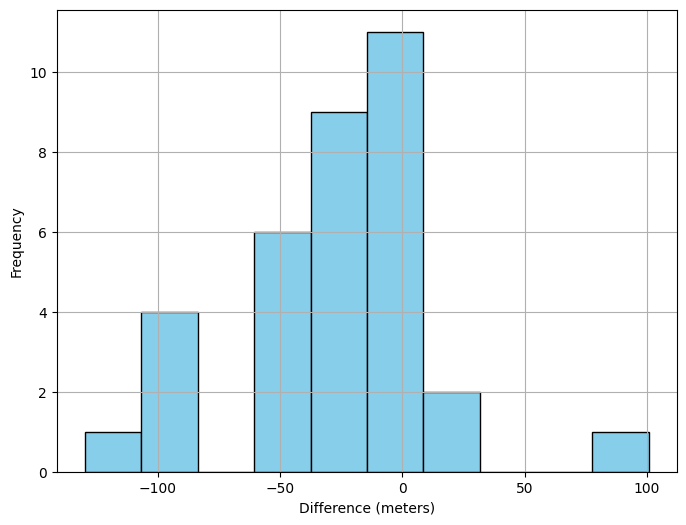

In [7]:
from geopy.distance import geodesic
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

distances_2_2 = []
distances_2 = []
highlighted_distances = []
total_distance = 0

def calculate_consecutive_geodesic_distances(points, distances_list):
    total = 0
    for i in range(1, len(points)):
        distance = geodesic(points[i-1], points[i]).meters
        total += distance
        distances_list.append(distance)
    return distances_list, total

consecutive_distances_km_2, total_distance = calculate_consecutive_geodesic_distances(path_nodes_2, distances_2)

valid_highlighted_indices = [path_nodes_2.index(node) for node in valid_highlighted_nodes_2 if node in path_nodes_2]

for i in range(1, len(valid_highlighted_indices)):
    start_index, end_index = valid_highlighted_indices[i-1], valid_highlighted_indices[i]
    highlighted_distance = np.sum(distances_2[start_index:end_index])
    highlighted_distances.append(highlighted_distance)

gpx_coordinates_obs = [(lat, lon) for lon, lat in observations_2_no_duplicates]
consecutive_distances_km_2, _ = calculate_consecutive_geodesic_distances(gpx_coordinates_obs, distances_2_2)

data = []
for i in range(max(len(highlighted_distances), len(distances_2_2))):
    row = [
        highlighted_distances[i] if i < len(highlighted_distances) else "", 
        distances_2_2[i] if i < len(distances_2_2) else "", 
        abs(highlighted_distances[i] - distances_2_2[i]) if i < len(highlighted_distances) and i < len(distances_2_2) else ""
    ]
    data.append(row)

headers = ["Path Length", "Geodesic", "distance_diff"]
print(tabulate(data, headers=headers, tablefmt="grid"))

if len(highlighted_distances) == len(distances_2_2):
    plt.figure(figsize=(8, 6))
    plt.hist(np.array(highlighted_distances) - np.array(distances_2_2), bins=10, edgecolor='black', color='skyblue')
    plt.xlabel("Difference (meters)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()
else:
    print("\nThe highlighted_distances and distances_2_2 arrays have different lengths. Cannot compute differences.")


In [8]:
from tabulate import tabulate
data = []
max_len = min(len(highlighted_distances), len(distances_2_2))
for i in range(max_len):
    path_length = highlighted_distances[i]
    geodesic = distances_2_2[i]
    distance_diff = abs(path_length - geodesic)

    if distance_diff > 100:
        data.append([i, path_length, geodesic, distance_diff])

print(tabulate(data, headers=["Index", "Path Length (m)", "Geodesic (m)", "Distance Diff (m)"], tablefmt="grid"))

significant_indices = [row[0] for row in data]
print("\nIndices with distance_diff > 100:")
print(significant_indices)


+---------+-------------------+----------------+---------------------+
|   Index |   Path Length (m) |   Geodesic (m) |   Distance Diff (m) |
+=========+===================+================+=====================+
|       0 |           43.2721 |       149.185  |             105.912 |
+---------+-------------------+----------------+---------------------+
|      10 |           80.5382 |       186.903  |             106.365 |
+---------+-------------------+----------------+---------------------+
|      20 |          160.634  |        59.9269 |             100.708 |
+---------+-------------------+----------------+---------------------+
|      31 |           34.1784 |       163.964  |             129.785 |
+---------+-------------------+----------------+---------------------+

Indices with distance_diff > 100:
[0, 10, 20, 31]


Total distance of the shortest path: 1546.79 meters
Total geodesic distance : 1185.89 meters

Observation to Matched Node Mapping (within Geofence):
  Obs Index  Obs Coord (lon, lat)      Matched Node Coord          Shapefile Index
-----------  ------------------------  ------------------------  -----------------
          0  (77.5907266, 12.9522814)  (77.5910327, 12.9530502)               4890
          1  (77.5912004, 12.9535473)  (77.591235, 12.9538022)                5100
          2  (77.591225, 12.9536187)   (77.591235, 12.9538022)                5100
          3  (77.5912314, 12.9536213)  (77.591235, 12.9538022)                5100
          4  (77.5913151, 12.9537918)  (77.5913069, 12.953776)                5095
          5  (77.5915686, 12.9544481)  (77.591551, 12.9544331)                4886
          6  (77.5918572, 12.955363)   (77.5919271, 12.9555743)               5864
          7  (77.5920331, 12.9557963)  (77.5920448, 12.9558165)               5858
          8  (77.5921

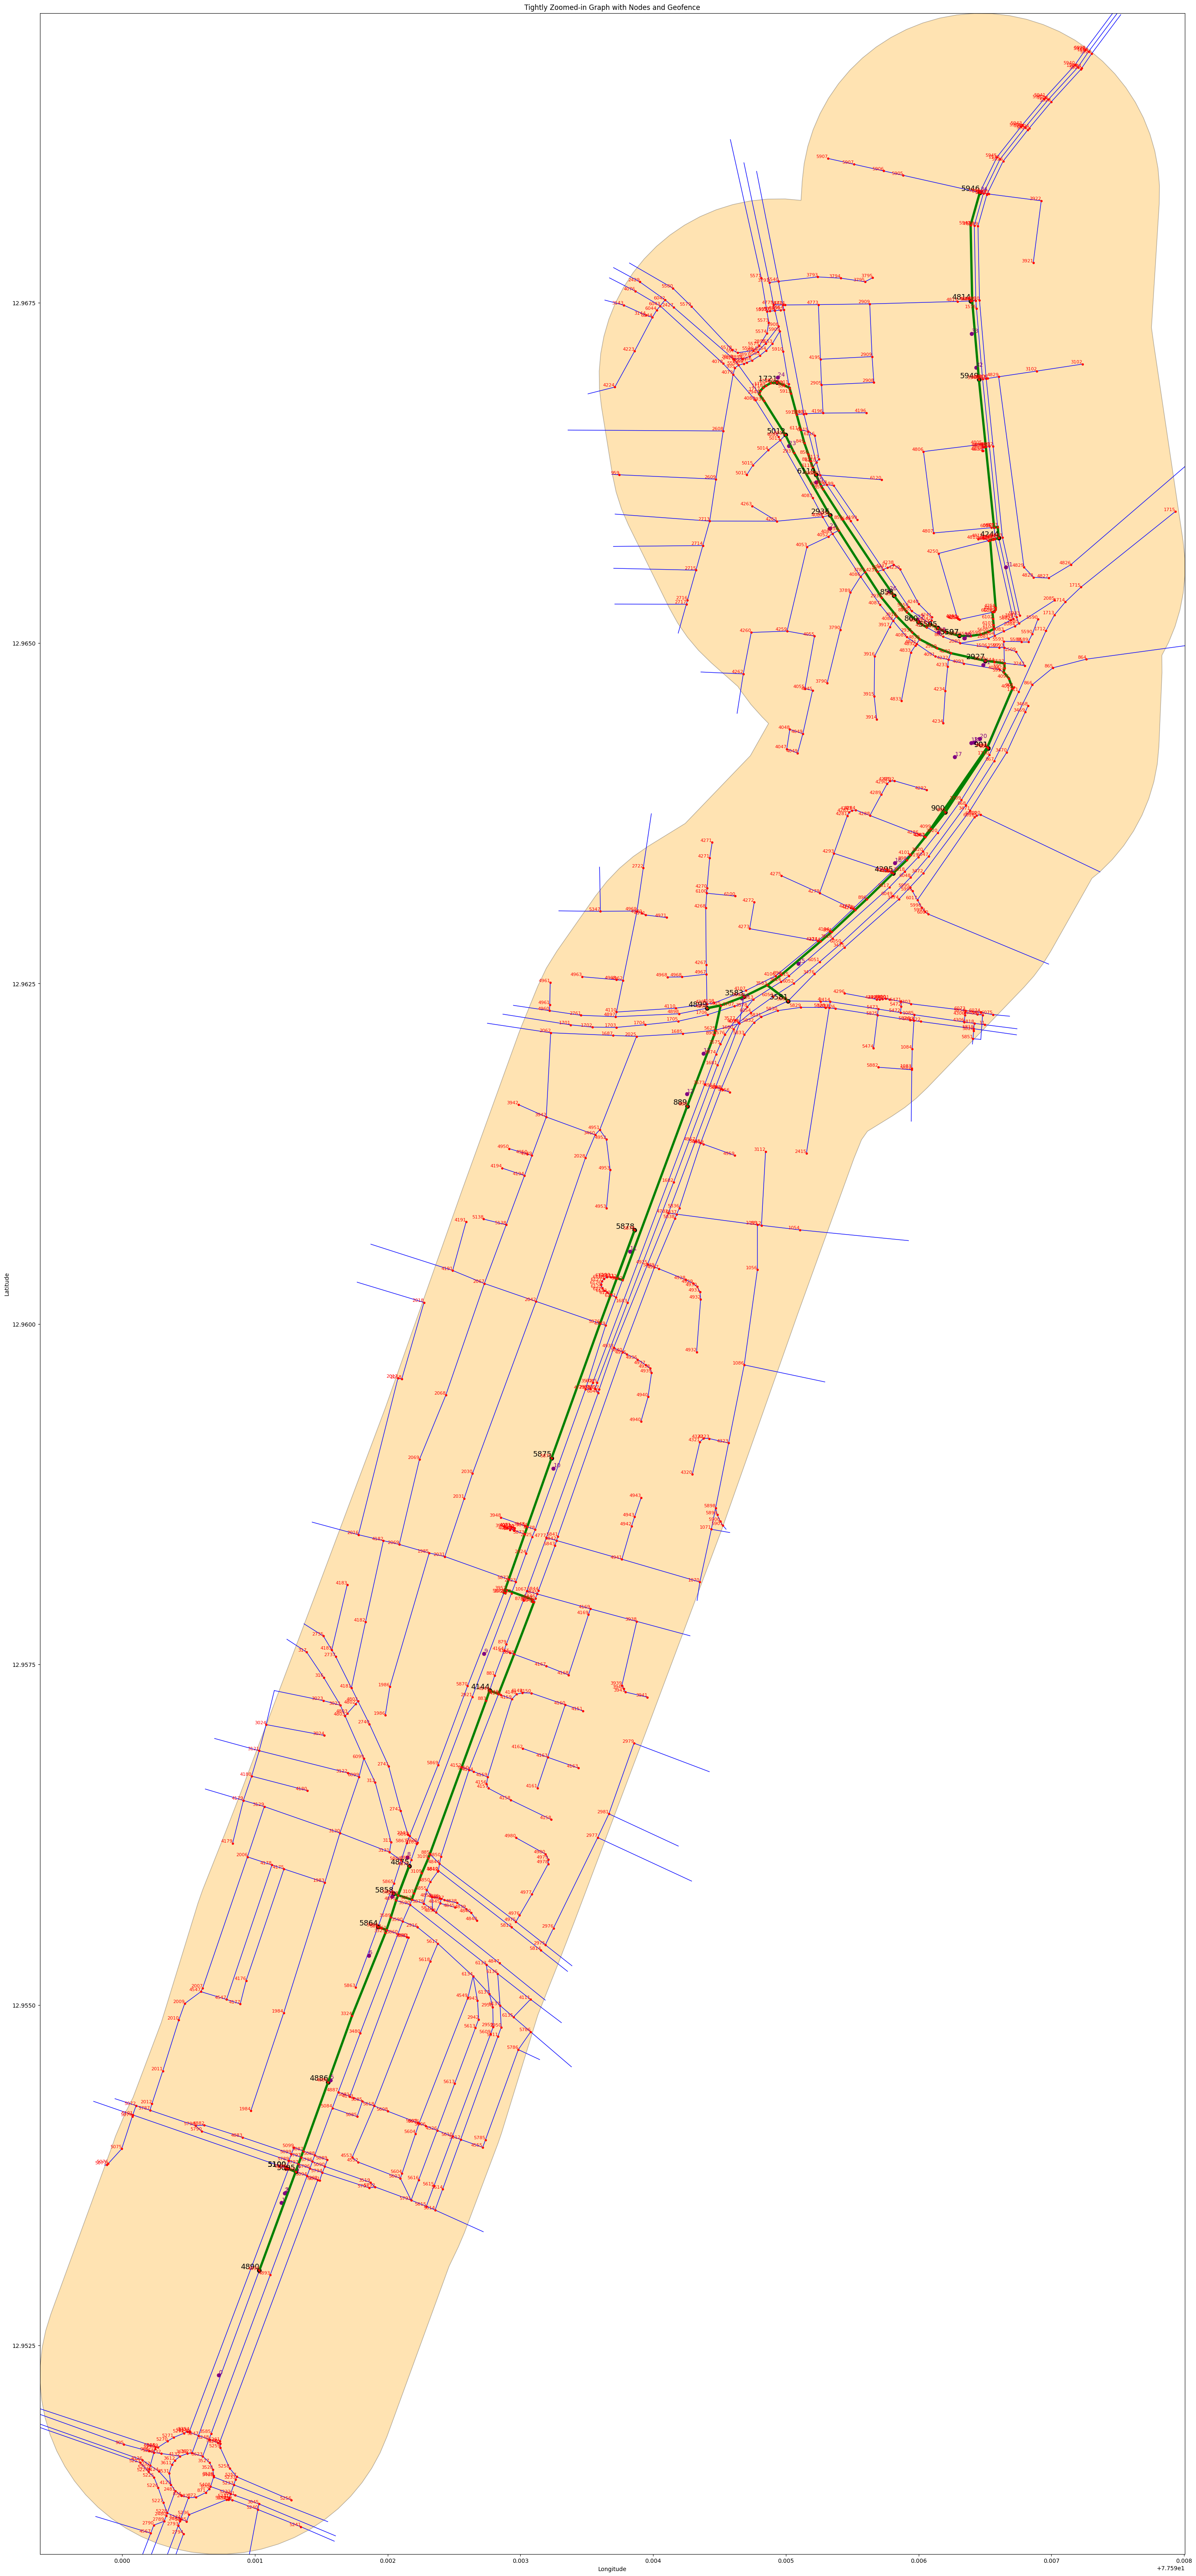

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import gpxpy
import geopandas as gpd
from shapely.geometry import LineString, Point
from geopy.distance import geodesic
from tabulate import tabulate

fp = "/Users/ashwin/Desktop/IIIT/Re_ OSM version - within 500m of the path/For_Route_g1_i150_500m.shp"
gpx_file_path = '/Users/ashwin/Desktop/IIIT/Re_ OSM version - within 500m of the path/ff3e72e1-90d5-4208-af3d-cf19a6c38fac_493.gpx'

data = gpd.read_file(fp)
G = nx.Graph()
coord_to_index = {}

for idx, line in enumerate(data.geometry):
    if line.geom_type == 'LineString':
        start, end = Point(line.coords[0]), Point(line.coords[-1])
        start_coord = tuple(start.coords[0])
        end_coord = tuple(end.coords[-1])
        G.add_node(start_coord, pos=start_coord)
        G.add_node(end_coord, pos=end_coord)
        G.add_edge(start_coord, end_coord, geometry=line)
        coord_to_index[start_coord] = idx
        coord_to_index[end_coord] = idx

with open(gpx_file_path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

start_index_2 = 80
end_index_2 = 120

observations_2 = [
    (point.longitude, point.latitude)
    for track in gpx.tracks
    for segment in track.segments
    for i, point in enumerate(segment.points)
    if start_index_2 <= i < end_index_2
]

observations_2_no_duplicates = [pt for i, pt in enumerate(observations_2) if i == 0 or pt != observations_2[i - 1]]

gpx_path = LineString(observations_2_no_duplicates)
gpx_gdf = gpd.GeoDataFrame(geometry=[gpx_path], crs="EPSG:4326").to_crs(epsg=3857)
geofence = gpx_gdf.buffer(150).to_crs(epsg=4326)

connected_components = sorted(nx.connected_components(G), key=len, reverse=True)

if connected_components:
    subgraph_2 = G.subgraph(connected_components[0]).copy()
    pos_2 = nx.get_node_attributes(subgraph_2, 'pos')

    nodes_in_geofence = [node for node, position in pos_2.items() if geofence.geometry[0].contains(Point(position))]
    edges_in_geofence = [edge for edge in subgraph_2.edges(data=True) if geofence.geometry[0].intersects(edge[2]['geometry'])]

    def geodesic_distance(a, b):
        return geodesic(a, b).kilometers

    def shortest_path_geodesic_weight(G, source, target):
        return nx.shortest_path(G, source=source, target=target, weight=lambda u, v, d: geodesic_distance(pos_2[u], pos_2[v]))

    fig, ax = plt.subplots(figsize=(80, 80))

    for edge in edges_in_geofence:
        line = edge[2]['geometry']
        x, y = line.xy
        ax.plot(x, y, color='blue', linewidth=1)

    valid_highlighted_nodes_2 = [tuple(coord) for coord in matched_coordinates_2 if tuple(coord) in pos_2]
    valid_nodes_in_geofence = [node for node in valid_highlighted_nodes_2 if Point(pos_2[node]).within(geofence.geometry[0])]

    for idx, node in enumerate(valid_nodes_in_geofence):
        x, y = node
        ax.plot(x, y, marker='o', color='black', markersize=7)
        node_index = coord_to_index.get((x, y), None)
        ax.text(x, y, str(node_index), fontsize=13, color='black', ha='right', va='bottom')

    for i, pt in enumerate(observations_2_no_duplicates):
        obs_point = Point(pt)
        if geofence.geometry[0].contains(obs_point):
            ax.plot(pt[0], pt[1], marker='o', color='purple', markersize=6)
            ax.text(pt[0], pt[1], str(i), fontsize=10, color='purple', ha='left', va='bottom')

    geofence.plot(ax=ax, color='orange', alpha=0.3, edgecolor='black')

    plotted_edges = set()
    total_shortest_path_distance = 0.0
    for i in range(len(valid_nodes_in_geofence) - 1):
        start = valid_nodes_in_geofence[i]
        end = valid_nodes_in_geofence[i + 1]
        if nx.has_path(subgraph_2, start, end):
            path = shortest_path_geodesic_weight(subgraph_2, start, end)
            segment_distance = 0.0
            for j in range(len(path) - 1):
                node_start = path[j]
                node_end = path[j + 1]
                dist = geodesic_distance(pos_2[node_start], pos_2[node_end])
                segment_distance += dist
                if (node_start, node_end) not in plotted_edges:
                    line = subgraph_2[node_start][node_end]['geometry']
                    if geofence.geometry[0].intersects(line):
                        intersected_line = line.intersection(geofence.geometry[0])
                        if isinstance(intersected_line, LineString):
                            x, y = intersected_line.xy
                            ax.plot(x, y, color='green', linewidth=4, linestyle='-')
                            plotted_edges.add((node_start, node_end))
            total_shortest_path_distance += segment_distance

    def calculate_geodesic_distance(points):
        total_distance = 0.0
        for i in range(1, len(points)):
            total_distance += geodesic(points[i - 1], points[i]).kilometers
        return total_distance

    total_observation_path_distance = calculate_geodesic_distance(observations_2_no_duplicates)
    print(f"Total distance of the shortest path: {total_shortest_path_distance * 1000:.2f} meters")
    print(f"Total geodesic distance : {total_observation_path_distance * 1000:.2f} meters")

    for node in nodes_in_geofence:
        x, y = pos_2[node]
        ax.plot(x, y, marker='o', color='red', markersize=3)
        node_index = coord_to_index.get((x, y), None)
        ax.text(x, y, str(node_index), fontsize=8, color='red', ha='right', va='bottom')

    mapping_table = []
    obs_counter = 0
    for i, pt in enumerate(observations_2_no_duplicates):
        obs_point = Point(pt)
        if geofence.geometry[0].contains(obs_point):
            if obs_counter < len(valid_nodes_in_geofence):
                matched_node = valid_nodes_in_geofence[obs_counter]
                matched_index = coord_to_index.get(matched_node, "N/A")
                mapping_table.append([i, pt, matched_node, matched_index])
                obs_counter += 1

    print("\nObservation to Matched Node Mapping (within Geofence):")
    print(tabulate(mapping_table, headers=["Obs Index", "Obs Coord (lon, lat)", "Matched Node Coord", "Shapefile Index"]))

    zoom_factor = 0.000001
    minx, miny, maxx, maxy = geofence.total_bounds
    ax.set_xlim(minx - zoom_factor, maxx + zoom_factor)
    ax.set_ylim(miny - zoom_factor, maxy + zoom_factor)
    plt.title("Tightly Zoomed-in Graph with Nodes and Geofence")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()


Candidate idx: 4782, Angle Difference: 0.00°, Distance Difference: 0.1054 km
Candidate idx: 4957, Angle Difference: 0.00°, Distance Difference: 0.1314 km
Candidate idx: 878, Angle Difference: 0.05°, Distance Difference: 0.0344 km
Candidate idx: 1067, Angle Difference: 0.07°, Distance Difference: 0.0311 km
Candidate idx: 4777, Angle Difference: 0.22°, Distance Difference: 0.0121 km
Candidate idx: 4925, Angle Difference: 0.25°, Distance Difference: 0.0857 km
Candidate idx: 6046, Angle Difference: 0.63°, Distance Difference: 0.0384 km
Candidate idx: 3627, Angle Difference: 0.69°, Distance Difference: 0.0394 km
Candidate idx: 4164, Angle Difference: 0.70°, Distance Difference: 0.0528 km
Candidate idx: 5835, Angle Difference: 0.71°, Distance Difference: 0.1359 km
Candidate idx: 1682, Angle Difference: 0.83°, Distance Difference: 0.1164 km
Candidate idx: 4933, Angle Difference: 0.83°, Distance Difference: 0.0536 km
Candidate idx: 879, Angle Difference: 0.85°, Distance Difference: 0.0506 km
C

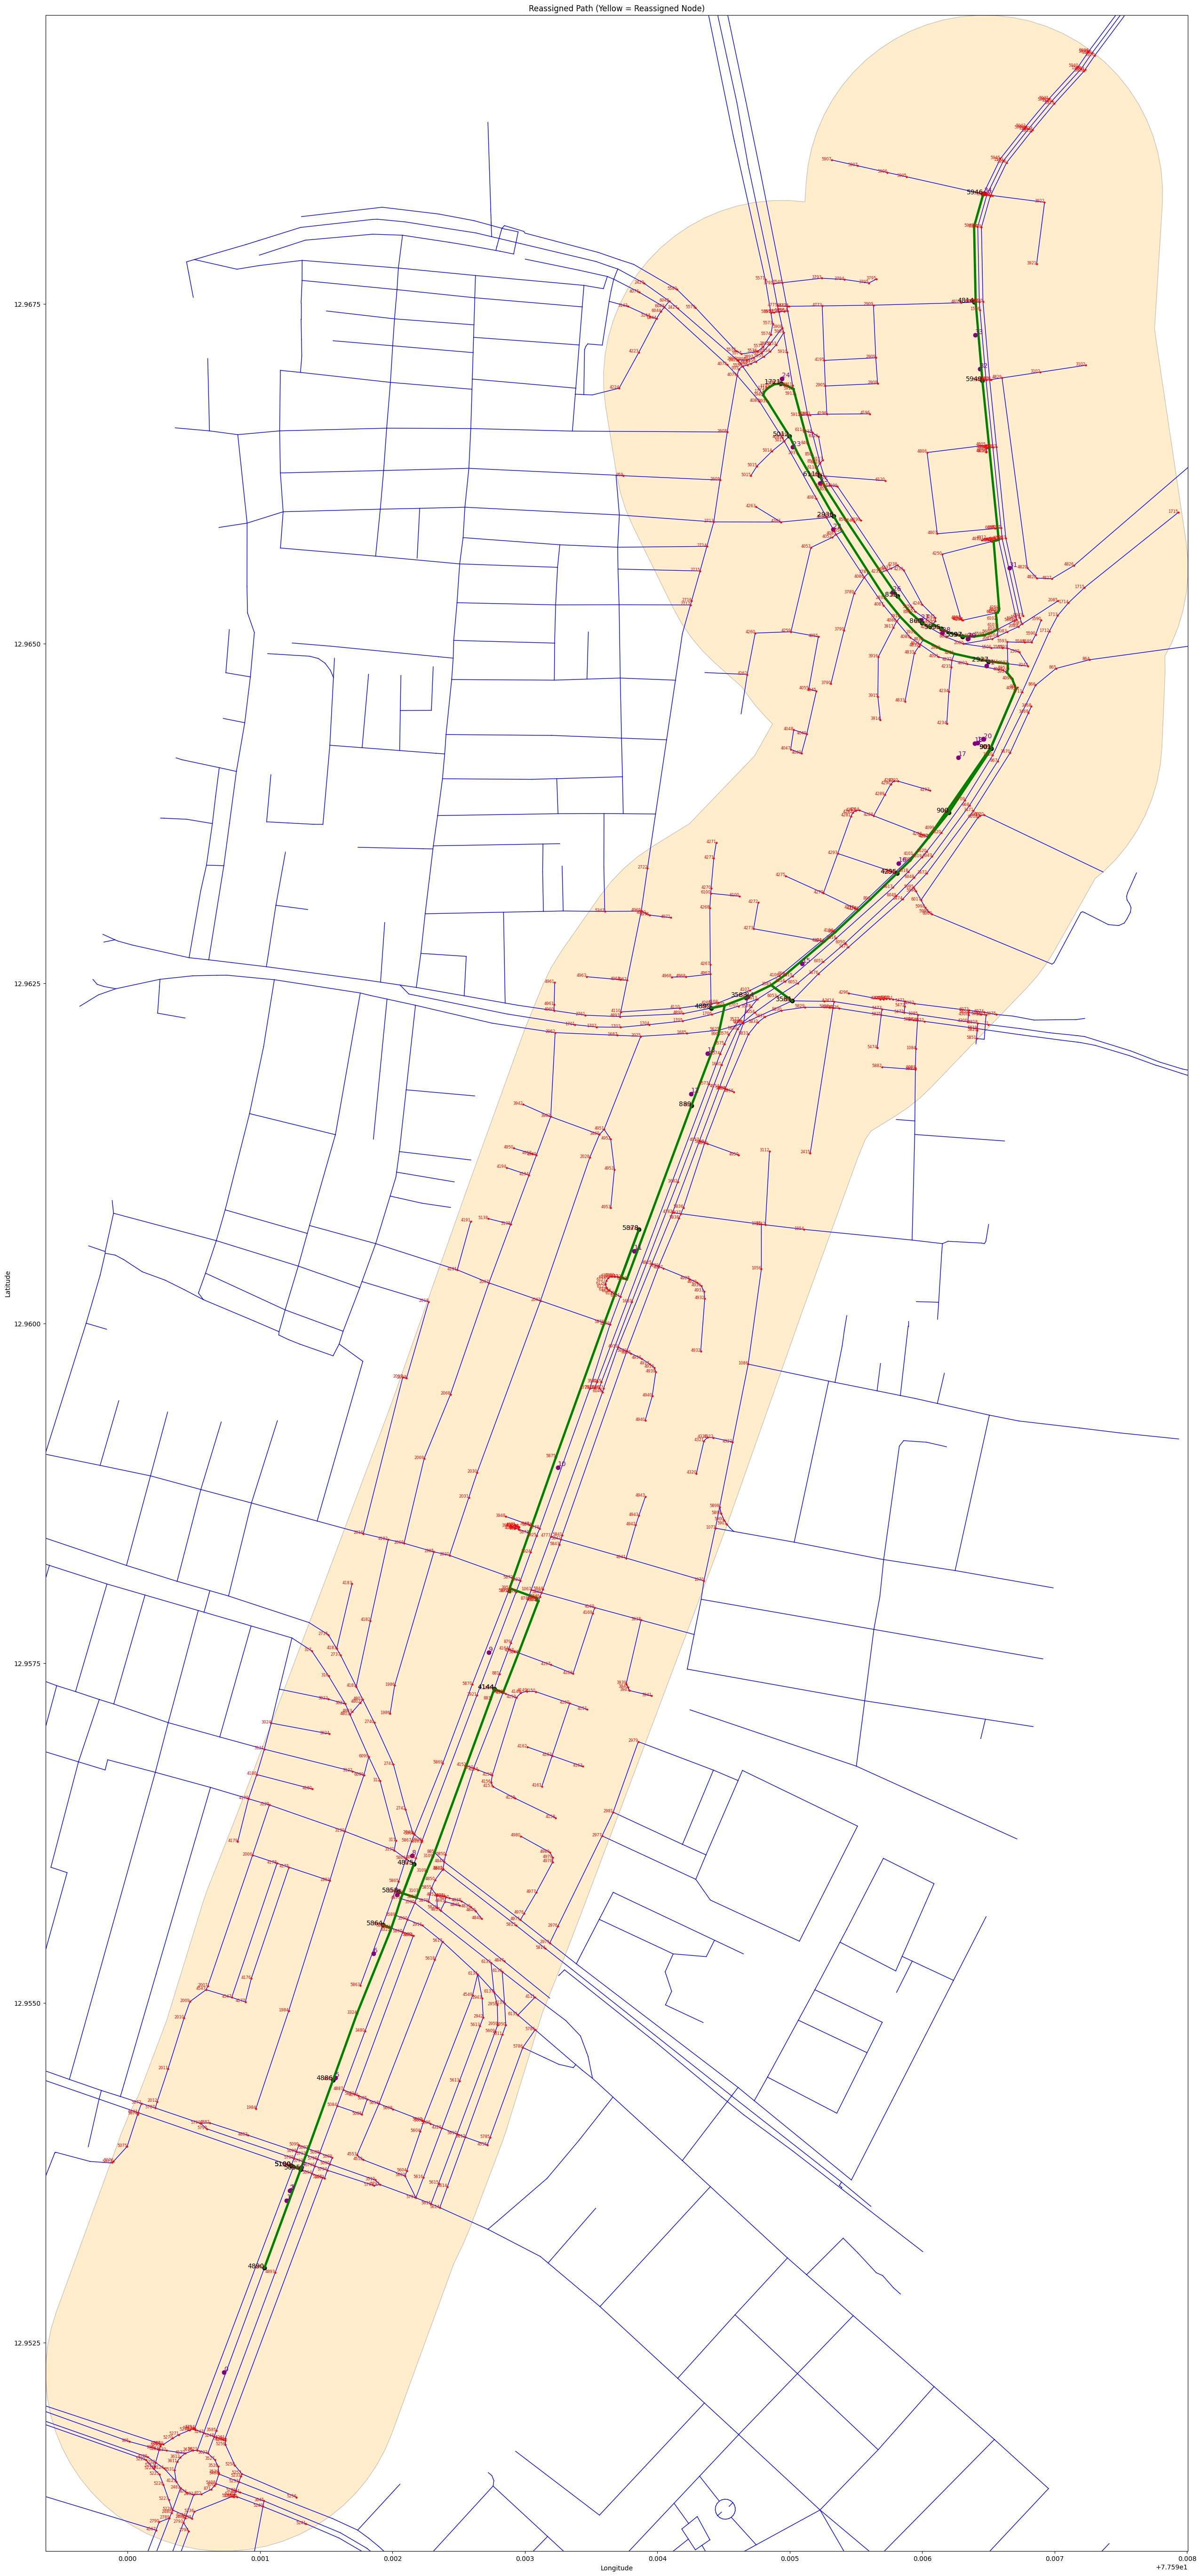

In [34]:
import networkx as nx
import matplotlib.pyplot as plt
import gpxpy
import geopandas as gpd
from shapely.geometry import LineString, Point
from geopy.distance import geodesic
import math
import numpy as np

fp = "/Users/ashwin/Desktop/IIIT/Re_ OSM version - within 500m of the path/For_Route_g1_i150_500m.shp"
gpx_file_path = '/Users/ashwin/Desktop/IIIT/Re_ OSM version - within 500m of the path/ff3e72e1-90d5-4208-af3d-cf19a6c38fac_493.gpx'

data = gpd.read_file(fp)
G = nx.Graph()
coord_to_index = {}

for idx, line in enumerate(data.geometry):
    if line.geom_type == 'LineString':
        start, end = Point(line.coords[0]), Point(line.coords[-1])
        start_coord = tuple(start.coords[0])
        end_coord = tuple(end.coords[-1])
        G.add_node(start_coord, pos=start_coord)
        G.add_node(end_coord, pos=end_coord)
        G.add_edge(start_coord, end_coord, geometry=line)
        coord_to_index[start_coord] = idx
        coord_to_index[end_coord] = idx

with open(gpx_file_path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

start_index = 80
end_index = 120

observations = [
    (point.longitude, point.latitude)
    for track in gpx.tracks
    for segment in track.segments
    for i, point in enumerate(segment.points)
    if start_index <= i < end_index
]

observations_2_no = [pt for i, pt in enumerate(observations) if i == 0 or pt != observations[i - 1]]
gpx_path = LineString(observations_2_no)
gpx_gdf = gpd.GeoDataFrame(geometry=[gpx_path], crs="EPSG:4326")
gpx_gdf_3857 = gpx_gdf.to_crs(epsg=3857)
geofence_buffered_3857 = gpx_gdf_3857.buffer(150)
geofence = geofence_buffered_3857.to_crs(epsg=4326)

connected_components = sorted(nx.connected_components(G), key=len, reverse=True)

if connected_components:
    subgraph = G.subgraph(connected_components[0]).copy()
    pos = nx.get_node_attributes(subgraph, 'pos')
    states_in_geofence = [node for node in pos if geofence.geometry[0].contains(Point(pos[node]))]

    def geodesic_distance(a, b):
        return geodesic(a, b).kilometers

    def shortest_path_distance(G, source, target):
        path = nx.shortest_path(G, source, target, weight=lambda u, v, d: geodesic_distance(pos[u], pos[v]))
        return path, sum(geodesic_distance(pos[path[i]], pos[path[i + 1]]) for i in range(len(path) - 1))

    def calculate_heading(p1, p2):
        lat1, lon1 = map(math.radians, p1)
        lat2, lon2 = map(math.radians, p2)
        d_lon = lon2 - lon1
        x = math.sin(d_lon) * math.cos(lat2)
        y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(d_lon)
        return (math.degrees(math.atan2(x, y)) + 360) % 360

    def angle_diff_signed(a, b):
        diff = (b - a + 360) % 360
        return diff - 360 if diff > 180 else diff

    def reassign_node(fixed_node, obs_heading, i):
        candidates = []
        obs_dist = geodesic(observations_2_no[i - 1], observations_2_no[i]).km
        for candidate in states_in_geofence:
            if not nx.has_path(subgraph, fixed_node, candidate):
                continue
            node_heading = calculate_heading(pos[fixed_node], pos[candidate])
            angle_difference = abs(angle_diff_signed(obs_heading, node_heading))
            _, dist_to_candidate = shortest_path_distance(subgraph, fixed_node, candidate)
            dist_difference = abs(dist_to_candidate - obs_dist)
            if angle_difference <= 5 and dist_difference <= 0.14:
                candidates.append((angle_difference, dist_difference, candidate))
        candidates.sort(key=lambda x: (x[0], x[1]))
        for cand in candidates:
            idx = coord_to_index.get(cand[2], 'N/A')
            print(f"Candidate idx: {idx}, Angle Difference: {cand[0]:.2f}°, Distance Difference: {cand[1]:.4f} km")
        for angle_diff, dist_diff, candidate in candidates:
            prev_node = reassigned_nodes[-1]
            next_node = tuple(matched_coordinates_2[i + 1]) if i + 1 < len(matched_coordinates_2) else None
            valid = True
            if nx.has_path(subgraph, prev_node, candidate):
                _, d1 = shortest_path_distance(subgraph, prev_node, candidate)
                if d1 * 1000 > 120:
                    valid = False
            if next_node and candidate in pos and next_node in pos and nx.has_path(subgraph, candidate, next_node):
                _, d2 = shortest_path_distance(subgraph, candidate, next_node)
                if d2 * 1000 > 120:
                    valid = False
            if valid:
                return candidate, (angle_diff, dist_diff)
        return None, None

    reassigned_nodes = [tuple(matched_coordinates_2[0])]
    reassigned_log = []
    reassignment_memory = {}
    reassignment_flags = set()

    max_len = min(len(highlighted_distances), len(distances_2_2))
    for i in range(max_len):
        path_length = highlighted_distances[i]
        geo_dist = distances_2_2[i]
        distance_diff = abs(path_length - geo_dist)
        if distance_diff > 100:
            reassignment_flags.add(i)

    to_process = list(range(1, min(len(matched_coordinates_2), len(observations_2_no))))
    forced_flags = set()

    while to_process:
        i = to_process.pop(0)
        fixed_node = reassigned_nodes[-1]
        target_node = tuple(matched_coordinates_2[i])
        original_index = coord_to_index.get(target_node, None)

        if original_index in reassignment_memory:
            reassigned = reassignment_memory[original_index]
            reassigned_nodes.append(reassigned)
            continue

        force_reassign = i in reassignment_flags or i in forced_flags
        if force_reassign:
            obs_heading = calculate_heading(observations_2_no[i - 1], observations_2_no[i])
            reassigned, candidate_info = reassign_node(fixed_node, obs_heading, i)
            if reassigned:
                reassigned_nodes.append(reassigned)
                idx = coord_to_index.get(reassigned, "N/A")
                reassignment_memory[original_index] = reassigned
                print(f"Reassigned: original {original_index} → new index: {idx}, angle: {candidate_info[0]:.2f}°, dist: {candidate_info[1]*1000:.2f} m")
                reassigned_log.append((target_node, reassigned, idx, candidate_info))

                if i + 1 < len(matched_coordinates_2):
                    next_node = tuple(matched_coordinates_2[i + 1])
                    if reassigned in pos and next_node in pos and nx.has_path(subgraph, reassigned, next_node):
                        _, d = shortest_path_distance(subgraph, reassigned, next_node)
                        if d * 1000 > 120:
                            forced_flags.add(i + 1)
                            if i + 1 not in to_process:
                                to_process.insert(0, i + 1)
            else:
                reassigned_nodes.append(fixed_node)
                idx = coord_to_index.get(fixed_node, "N/A")
                print(f"[OBS {i}] Retained (fallback): index {idx}, Node {fixed_node}, Obs {observations_2_no[i]}")
        else:
            reassigned_nodes.append(target_node)

    fig, ax = plt.subplots(figsize=(70, 70))

    for edge in subgraph.edges(data=True):
        line = edge[2]['geometry']
        x, y = line.xy
        ax.plot(x, y, color='blue', linewidth=1)

    for node in states_in_geofence:
        x, y = pos[node]
        ax.plot(x, y, marker='o', color='red', markersize=2)
        idx = coord_to_index.get((x, y), None)
        if idx is not None:
            ax.text(x, y, str(idx), fontsize=6, color='red', ha='right')

    for node in reassigned_nodes:
        if node in pos and geofence.geometry[0].contains(Point(pos[node])):
            x, y = node
            color = 'blue' if any(node == r[1] for r in reassigned_log) else 'black'
            ax.plot(x, y, marker='o', color=color, markersize=6)
            idx = coord_to_index.get((x, y), None)
            if idx is not None:
                ax.text(x, y, str(idx), fontsize=10, color=color, ha='right')

    for i, pt in enumerate(observations_2_no):
        obs_point = Point(pt)
        if geofence.geometry[0].contains(obs_point):
            ax.plot(pt[0], pt[1], marker='o', color='purple', markersize=6)
            ax.text(pt[0], pt[1], str(i), fontsize=10, color='purple', ha='left', va='bottom')

    plotted_edges = set()
    print("--Segment Distances--")
    for i in range(1, len(reassigned_nodes)):
        a, b = reassigned_nodes[i - 1], reassigned_nodes[i]
        if a in pos and b in pos and nx.has_path(subgraph, a, b):
            path, d = shortest_path_distance(subgraph, a, b)
            print(f"Segment {i}: {d*1000:.2f} m")
            for j in range(len(path) - 1):
                edge_geom = subgraph[path[j]][path[j + 1]]['geometry']
                if (path[j], path[j + 1]) not in plotted_edges:
                    x, y = edge_geom.xy
                    ax.plot(x, y, color='green', linewidth=3.5)
                    plotted_edges.add((path[j], path[j + 1]))

    geofence.plot(ax=ax, color='orange', alpha=0.2, edgecolor='black')
    minx, miny, maxx, maxy = geofence.total_bounds
    ax.set_xlim(minx - 1e-6, maxx + 1e-6)
    ax.set_ylim(miny - 1e-6, maxy + 1e-6)
    plt.title("Reassigned Path (Yellow = Reassigned Node)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()


Candidate idx: 4782, Angle Difference: 0.00°, Distance Difference: 105.4 m
Candidate idx: 878, Angle Difference: 0.05°, Distance Difference: 34.4 m
Candidate idx: 1067, Angle Difference: 0.07°, Distance Difference: 31.1 m
Candidate idx: 4777, Angle Difference: 0.22°, Distance Difference: 12.1 m
Candidate idx: 4925, Angle Difference: 0.25°, Distance Difference: 85.7 m
Candidate idx: 6046, Angle Difference: 0.63°, Distance Difference: 38.4 m
Candidate idx: 3627, Angle Difference: 0.69°, Distance Difference: 39.4 m
Candidate idx: 4164, Angle Difference: 0.70°, Distance Difference: 52.8 m
Candidate idx: 1682, Angle Difference: 0.83°, Distance Difference: 116.4 m
Candidate idx: 4933, Angle Difference: 0.83°, Distance Difference: 53.6 m
Candidate idx: 879, Angle Difference: 0.85°, Distance Difference: 50.6 m
Candidate idx: 5839, Angle Difference: 0.95°, Distance Difference: 91.6 m
Candidate idx: 5840, Angle Difference: 1.13°, Distance Difference: 61.0 m
Candidate idx: 5838, Angle Difference:

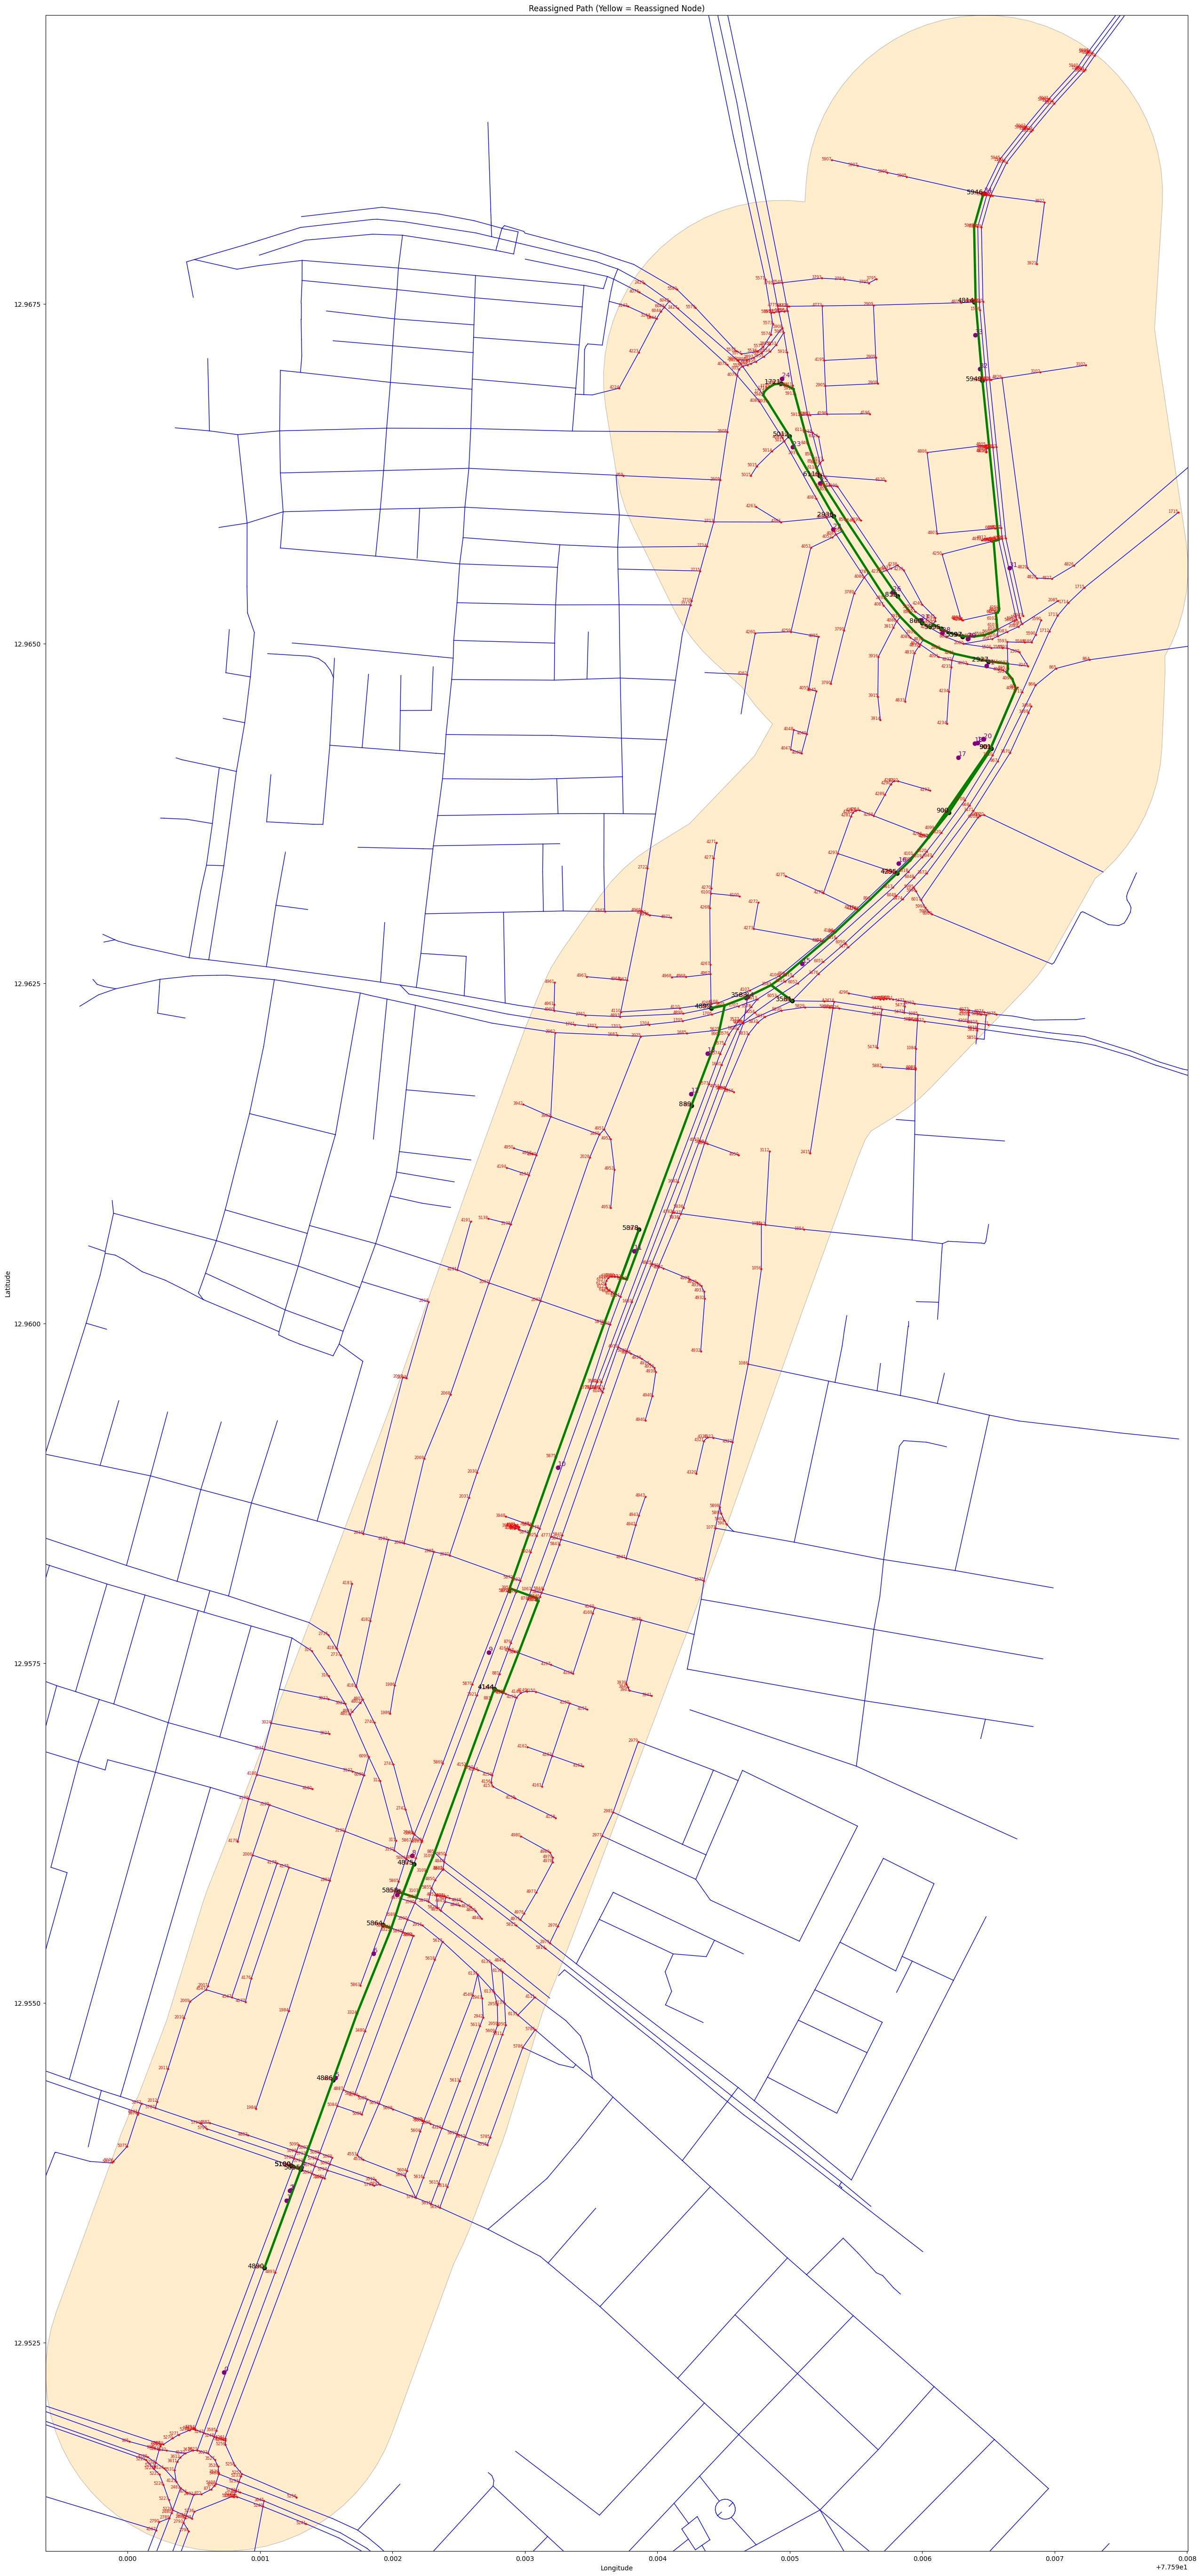

In [36]:
import networkx as nx
import matplotlib.pyplot as plt
import gpxpy
import geopandas as gpd
from shapely.geometry import LineString, Point
from geopy.distance import geodesic
import math
import numpy as np

fp = "/Users/ashwin/Desktop/IIIT/Re_ OSM version - within 500m of the path/For_Route_g1_i150_500m.shp"
gpx_file_path = '/Users/ashwin/Desktop/IIIT/Re_ OSM version - within 500m of the path/ff3e72e1-90d5-4208-af3d-cf19a6c38fac_493.gpx'

data = gpd.read_file(fp)
G = nx.Graph()
coord_to_index = {}

for idx, line in enumerate(data.geometry):
    if line.geom_type == 'LineString':
        start, end = Point(line.coords[0]), Point(line.coords[-1])
        start_coord = tuple(start.coords[0])
        end_coord = tuple(end.coords[-1])
        G.add_node(start_coord, pos=start_coord)
        G.add_node(end_coord, pos=end_coord)
        G.add_edge(start_coord, end_coord, geometry=line)
        coord_to_index[start_coord] = idx
        coord_to_index[end_coord] = idx

with open(gpx_file_path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

start_index = 80
end_index = 120

observations = [
    (point.longitude, point.latitude)
    for track in gpx.tracks
    for segment in track.segments
    for i, point in enumerate(segment.points)
    if start_index <= i < end_index
]

observations_2_no = [pt for i, pt in enumerate(observations) if i == 0 or pt != observations[i - 1]]
gpx_path = LineString(observations_2_no)
gpx_gdf = gpd.GeoDataFrame(geometry=[gpx_path], crs="EPSG:4326")
gpx_gdf_3857 = gpx_gdf.to_crs(epsg=3857)
geofence_buffered_3857 = gpx_gdf_3857.buffer(150)
geofence = geofence_buffered_3857.to_crs(epsg=4326)

connected_components = sorted(nx.connected_components(G), key=len, reverse=True)

if connected_components:
    subgraph = G.subgraph(connected_components[0]).copy()
    pos = nx.get_node_attributes(subgraph, 'pos')
    states_in_geofence = [node for node in pos if geofence.geometry[0].contains(Point(pos[node]))]

    def geodesic_distance(a, b):
        return geodesic(a, b).kilometers

    def shortest_path_distance(G, source, target):
        path = nx.shortest_path(G, source, target, weight=lambda u, v, d: geodesic_distance(pos[u], pos[v]))
        return path, sum(geodesic_distance(pos[path[i]], pos[path[i + 1]]) for i in range(len(path) - 1))

    def calculate_heading(p1, p2):
        lat1, lon1 = map(math.radians, p1)
        lat2, lon2 = map(math.radians, p2)
        d_lon = lon2 - lon1
        x = math.sin(d_lon) * math.cos(lat2)
        y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(d_lon)
        return (math.degrees(math.atan2(x, y)) + 360) % 360

    def angle_diff_signed(a, b):
        diff = (b - a + 360) % 360
        return diff - 360 if diff > 180 else diff

    def has_valid_reassignment(fixed_node, obs_heading, i):
        obs_dist = geodesic(observations_2_no[i - 1], observations_2_no[i]).km
        for candidate in states_in_geofence:
            if not nx.has_path(subgraph, fixed_node, candidate):
                continue
            node_heading = calculate_heading(pos[fixed_node], pos[candidate])
            angle_diff = abs(angle_diff_signed(obs_heading, node_heading))
            if angle_diff > 5:
                continue
            _, path_dist = shortest_path_distance(subgraph, fixed_node, candidate)
            if abs(path_dist - obs_dist) > 0.12:
                continue
            prev_node = reassigned_nodes[-1]
            next_node = tuple(matched_coordinates_2[i + 1]) if i + 1 < len(matched_coordinates_2) else None
            if nx.has_path(subgraph, prev_node, candidate):
                _, d1 = shortest_path_distance(subgraph, prev_node, candidate)
                if d1 * 1000 > 120:
                    continue
            if next_node and candidate in pos and next_node in pos and nx.has_path(subgraph, candidate, next_node):
                _, d2 = shortest_path_distance(subgraph, candidate, next_node)
                if d2 * 1000 > 120:
                    continue
            return True
        return False

    def reassign_node(fixed_node, obs_heading, i):
        candidates = []
        obs_dist = geodesic(observations_2_no[i - 1], observations_2_no[i]).km
        for candidate in states_in_geofence:
            if not nx.has_path(subgraph, fixed_node, candidate):
                continue
            node_heading = calculate_heading(pos[fixed_node], pos[candidate])
            angle_difference = abs(angle_diff_signed(obs_heading, node_heading))
            _, dist_to_candidate = shortest_path_distance(subgraph, fixed_node, candidate)
            dist_difference = abs(dist_to_candidate - obs_dist)
            if angle_difference <= 5 and dist_difference <= 0.12:
                candidates.append((angle_difference, dist_difference, candidate))
        candidates.sort(key=lambda x: (x[0], x[1]))
        for cand in candidates:
            idx = coord_to_index.get(cand[2], 'N/A')
            print(f"Candidate idx: {idx}, Angle Difference: {cand[0]:.2f}°, Distance Difference: {cand[1]*1000:.1f} m")
        for angle_diff, dist_diff, candidate in candidates:
            prev_node = reassigned_nodes[-1]
            next_node = tuple(matched_coordinates_2[i + 1]) if i + 1 < len(matched_coordinates_2) else None
            valid = True
            if nx.has_path(subgraph, prev_node, candidate):
                _, d1 = shortest_path_distance(subgraph, prev_node, candidate)
                if d1 * 1000 > 120:
                    valid = False
            if next_node and candidate in pos and next_node in pos and nx.has_path(subgraph, candidate, next_node):
                _, d2 = shortest_path_distance(subgraph, candidate, next_node)
                if d2 * 1000 > 120:
                    valid = False
            if valid:
                return candidate, (angle_diff, dist_diff)
        return None, None

    reassigned_nodes = [tuple(matched_coordinates_2[0])]
    reassigned_log = []
    reassignment_memory = {}
    reassignment_flags = set()

    max_len = min(len(highlighted_distances), len(distances_2_2))
    for i in range(max_len):
        path_length = highlighted_distances[i]
        geo_dist = distances_2_2[i]
        distance_diff = abs(path_length - geo_dist)
        if distance_diff > 100:
            reassignment_flags.add(i)

    to_process = list(range(1, min(len(matched_coordinates_2), len(observations_2_no))))
    forced_flags = set()

    while to_process:
        i = to_process.pop(0)
        fixed_node = reassigned_nodes[-1]
        target_node = tuple(matched_coordinates_2[i])
        original_index = coord_to_index.get(target_node, None)

        if original_index in reassignment_memory:
            reassigned = reassignment_memory[original_index]
            reassigned_nodes.append(reassigned)
            continue

        force_reassign = i in reassignment_flags or i in forced_flags
        if force_reassign:
            obs_heading = calculate_heading(observations_2_no[i - 1], observations_2_no[i])
            reassigned, candidate_info = reassign_node(fixed_node, obs_heading, i)
            if reassigned:
                reassigned_nodes.append(reassigned)
                idx = coord_to_index.get(reassigned, "N/A")
                reassignment_memory[original_index] = reassigned
                print(f"Reassigned: original {original_index} → new index: {idx}, angle: {candidate_info[0]:.2f}°, dist: {candidate_info[1]*1000:.2f} m")
                reassigned_log.append((target_node, reassigned, idx, candidate_info))

                if i + 1 < len(matched_coordinates_2):
                    next_node = tuple(matched_coordinates_2[i + 1])
                    if reassigned in pos and next_node in pos and nx.has_path(subgraph, reassigned, next_node):
                        _, d = shortest_path_distance(subgraph, reassigned, next_node)
                        if d * 1000 > 120:
                            obs_heading_next = calculate_heading(observations_2_no[i], observations_2_no[i + 1])
                            if has_valid_reassignment(reassigned, obs_heading_next, i + 1):
                                forced_flags.add(i + 1)
                                if i + 1 not in to_process:
                                    to_process.insert(0, i + 1)
            else:
                reassigned_nodes.append(fixed_node)
                idx = coord_to_index.get(fixed_node, "N/A")
                print(f"[OBS {i}] Retained (fallback): index {idx}, Node {fixed_node}, Obs {observations_2_no[i]}")

                if i + 1 < len(matched_coordinates_2):
                    current_node = reassigned_nodes[-1]
                    next_node = tuple(matched_coordinates_2[i + 1])
                    if current_node in pos and next_node in pos and nx.has_path(subgraph, current_node, next_node):
                        _, d = shortest_path_distance(subgraph, current_node, next_node)
                        if d * 1000 > 120:
                            obs_heading_next = calculate_heading(observations_2_no[i], observations_2_no[i + 1])
                            if has_valid_reassignment(current_node, obs_heading_next, i + 1):
                                forced_flags.add(i + 1)
                                if i + 1 not in to_process:
                                    to_process.insert(0, i + 1)
        else:
            reassigned_nodes.append(target_node)

    fig, ax = plt.subplots(figsize=(70, 70))

    for edge in subgraph.edges(data=True):
        line = edge[2]['geometry']
        x, y = line.xy
        ax.plot(x, y, color='blue', linewidth=1)

    for node in states_in_geofence:
        x, y = pos[node]
        ax.plot(x, y, marker='o', color='red', markersize=2)
        idx = coord_to_index.get((x, y), None)
        if idx is not None:
            ax.text(x, y, str(idx), fontsize=6, color='red', ha='right')

    for node in reassigned_nodes:
        if node in pos and geofence.geometry[0].contains(Point(pos[node])):
            x, y = node
            color = 'blue' if any(node == r[1] for r in reassigned_log) else 'black'
            ax.plot(x, y, marker='o', color=color, markersize=6)
            idx = coord_to_index.get((x, y), None)
            if idx is not None:
                ax.text(x, y, str(idx), fontsize=10, color=color, ha='right')

    for i, pt in enumerate(observations_2_no):
        obs_point = Point(pt)
        if geofence.geometry[0].contains(obs_point):
            ax.plot(pt[0], pt[1], marker='o', color='purple', markersize=6)
            ax.text(pt[0], pt[1], str(i), fontsize=10, color='purple', ha='left', va='bottom')

    plotted_edges = set()
    print("--Segment Distances--")
    for i in range(1, len(reassigned_nodes)):
        a, b = reassigned_nodes[i - 1], reassigned_nodes[i]
        if a in pos and b in pos and nx.has_path(subgraph, a, b):
            path, d = shortest_path_distance(subgraph, a, b)
            print(f"Segment {i}: {d*1000:.2f} m")
            for j in range(len(path) - 1):
                edge_geom = subgraph[path[j]][path[j + 1]]['geometry']
                if (path[j], path[j + 1]) not in plotted_edges:
                    x, y = edge_geom.xy
                    ax.plot(x, y, color='green', linewidth=3.5)
                    plotted_edges.add((path[j], path[j + 1]))

    geofence.plot(ax=ax, color='orange', alpha=0.2, edgecolor='black')
    minx, miny, maxx, maxy = geofence.total_bounds
    ax.set_xlim(minx - 1e-6, maxx + 1e-6)
    ax.set_ylim(miny - 1e-6, maxy + 1e-6)
    plt.title("Reassigned Path (Yellow = Reassigned Node)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

In [28]:
from tabulate import tabulate
mapping_table = []
for i, (obs_coord, reassigned_node) in enumerate(zip(observations_2_no_duplicates, reassigned_nodes)):
    if reassigned_node in coord_to_index:
        node_index = coord_to_index[reassigned_node]
    else:
        node_index = "N/A"
    mapping_table.append([i, obs_coord, reassigned_node, node_index])

print("\nObservation to Reassigned Node Mapping Table:")
print(tabulate(mapping_table, headers=["Obs Index", "Obs Coord (lon, lat)", "Reassigned Node", "Shapefile Index"]))


Observation to Reassigned Node Mapping Table:
  Obs Index  Obs Coord (lon, lat)      Reassigned Node             Shapefile Index
-----------  ------------------------  ------------------------  -----------------
          0  (77.5907266, 12.9522814)  (77.5910327, 12.9530502)               4890
          1  (77.5912004, 12.9535473)  (77.591235, 12.9538022)                5100
          2  (77.591225, 12.9536187)   (77.591235, 12.9538022)                5100
          3  (77.5912314, 12.9536213)  (77.591235, 12.9538022)                5100
          4  (77.5913151, 12.9537918)  (77.5913069, 12.953776)                5095
          5  (77.5915686, 12.9544481)  (77.591551, 12.9544331)                4886
          6  (77.5918572, 12.955363)   (77.5919271, 12.9555743)               5864
          7  (77.5920331, 12.9557963)  (77.5920448, 12.9558165)               5858
          8  (77.5921469, 12.9560837)  (77.5921615, 12.9560201)               4875
          9  (77.5927254, 12.9575791)  (

In [29]:
from tabulate import tabulate
print("\n-- Detailed Segment Distance Comparison Table --")

table_data = []
header = [
    "Obs Index",
    "Matched Index",
    "Reassigned Index",
    "Geodesic (m)",
    "Matched Path (m)",
    "Reassigned Path (m)",
    "|Matched - Geodesic| (m)",
    "|Reassigned - Geodesic| (m)"
]

total_geodesic = 0
total_matched_path = 0
total_reassigned_path = 0

for i in range(1, len(observations_2_no_duplicates)):
    obs1 = observations_2_no_duplicates[i - 1]
    obs2 = observations_2_no_duplicates[i]
    geod = geodesic(obs1, obs2).meters 

    matched1 = tuple(matched_coordinates_2[i - 1])
    matched2 = tuple(matched_coordinates_2[i])
    matched_path_len = 0
    if matched1 in pos and matched2 in pos and nx.has_path(subgraph, matched1, matched2):
        _, matched_path_len = shortest_path_distance(subgraph, matched1, matched2)
        matched_path_len *= 1000  

    reassigned1 = tuple(reassigned_nodes[i - 1])
    reassigned2 = tuple(reassigned_nodes[i])
    reassigned_path_len = 0
    if reassigned1 in pos and reassigned2 in pos and nx.has_path(subgraph, reassigned1, reassigned2):
        _, reassigned_path_len = shortest_path_distance(subgraph, reassigned1, reassigned2)
        reassigned_path_len *= 1000  

    total_geodesic += geod
    total_matched_path += matched_path_len
    total_reassigned_path += reassigned_path_len

    matched_idx = coord_to_index.get(matched2, "N/A")
    reassigned_idx = coord_to_index.get(reassigned2, "N/A")

    table_data.append([
        i,
        matched_idx,
        reassigned_idx,
        round(geod, 4),
        round(matched_path_len, 4),
        round(reassigned_path_len, 4),
        round(abs(matched_path_len - geod), 4),
        round(abs(reassigned_path_len - geod), 4)
    ])

print(tabulate(table_data, headers=header, tablefmt="rounded_grid"))

abs_error_matched = abs(total_matched_path - total_geodesic)
abs_error_reassigned = abs(total_reassigned_path - total_geodesic)
percent_error_matched = (abs_error_matched / total_geodesic) * 100
percent_error_reassigned = (abs_error_reassigned / total_geodesic) * 100

print("\n-- Total Distances and Errors --")
print(f"Total Geodesic Distance:           {round(total_geodesic, 4)} meters")
print(f"Total Matched Path Length:         {round(total_matched_path, 4)} meters")
print(f"Total Reassigned Path Length:      {round(total_reassigned_path, 4)} meters")
print(f"|Matched - Geodesic| Error:        {round(abs_error_matched, 4)} meters ({round(percent_error_matched, 2)}%)")
print(f"|Reassigned - Geodesic| Error:     {round(abs_error_reassigned, 4)} meters ({round(percent_error_reassigned, 2)}%)")



-- Detailed Segment Distance Comparison Table --
╭─────────────┬─────────────────┬────────────────────┬────────────────┬────────────────────┬───────────────────────┬────────────────────────────┬───────────────────────────────╮
│   Obs Index │   Matched Index │   Reassigned Index │   Geodesic (m) │   Matched Path (m) │   Reassigned Path (m) │   |Matched - Geodesic| (m) │   |Reassigned - Geodesic| (m) │
├─────────────┼─────────────────┼────────────────────┼────────────────┼────────────────────┼───────────────────────┼────────────────────────────┼───────────────────────────────┤
│           1 │            5100 │               5100 │        60.999  │            43.2721 │               43.2721 │                    17.7269 │                       17.7269 │
├─────────────┼─────────────────┼────────────────────┼────────────────┼────────────────────┼───────────────────────┼────────────────────────────┼───────────────────────────────┤
│           2 │            5100 │               5100 │      